**BIVARIATE**

* Categorical vs Categorical Target --> Count + pct for each category and target category; Count + pct for each target category; Grouped count plot with hue=target; Grouped bar plot with percentages with hue=target and lines indicating target percentages without grouping

* Categorical vs Numerical Target --> Descibe for numerical target alone and for each category; Boxplot for each category with reference line with mean(median) for target alone; overlapping distributions for each value of categorical variable; QQ-plot 

* Numerical vs Categorical Target --> Describe for numerical variable alone and for each target category; Boxplot for each category with reference line with mean (median) for variable alone; overlapping distributions for each value of target variable; QQ-plot

* Numerical vs Numerical target --> Describe for both variable and target; Correlation values; Scatterplot


**TRIVARIATE**

* 2 Categorical vs Categorical target --> Count + pct for each category and target category; Count + pct for each target category; For each value of target, two heatmaps: one with percentages of the corresponding value for each pair of category values, and one with the difference between the first one, and the pct of the target value without grouping.

* 2 categorical vs numerical target --> Grouped boxplot with x=categorical, y=target, hue=categorical

* 1 Categorical, 1 Numerical vs Categorical target --> Grouped boxplot with x=Categorical, y=numerical, hue=target

* 1 Categorical, 1 Numerical vs Numerical target --> Scatterplot with hue=categorical

* 2 Numerical vs Categorical target --> Scatterplot with hue=target

* 2 Numerical vs numerical target --> heatmap


In [1]:
'''
Helper functions to do EDA
'''

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
from dython import nominal

In [2]:
sns.__version__

'0.11.0'

## Read Data

In [3]:
from sklearn.datasets import load_iris, load_diabetes, load_boston, fetch_openml

#### Fish dataset

In [4]:
fish = fetch_openml("fishcatch")

/home/edoardo/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:373: UserWarning: Multiple active versions of the dataset matching the name fishcatch exist. Versions may be fundamentally different, returning version 1.
  warn("Multiple active versions of the dataset matching the name"


In [5]:
df_fish = pd.DataFrame(fish.data, columns=fish.feature_names)
df_fish[fish.target_names[0]] = fish.target

In [6]:
df_fish["Species"] = df_fish["Species"].astype("category")
df_fish["Sex"] = df_fish["Sex"].astype("category")

In [7]:
df_fish.head()

,Species,Length1,Length2,Length3,Height,Width,Sex,class
0,0.0,23.2,25.4,30.0,38.4,13.4,NaN,242.0
1,0.0,24.0,26.3,31.2,40.0,13.8,NaN,290.0
2,0.0,23.9,26.5,31.1,39.8,15.1,NaN,340.0
3,0.0,26.3,29.0,33.5,38.0,13.3,NaN,363.0
4,0.0,26.5,29.0,34.0,36.6,15.1,NaN,430.0


#### Titanic dataset

In [133]:
DATA_PATH = os.path.join(os.getcwd(), 'titanic')

In [134]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [135]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [136]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [137]:
train_df["Pclass"] = train_df["Pclass"].astype("category") 
train_df["Survived"] = train_df["Survived"].astype("category") 

## Charts

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
#del sys.modules['AutoEDA']
#del test

In [17]:
import sys, importlib
#importlib.reload(sys.modules['AutoEDA'])
import AutoEDA.AutoEDA as eda
#import AutoEDA as eda

In [18]:
%matplotlib inline

In [19]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [42]:
eda.compute_association(dataframe, "Pclass", "categorical","Ticket", "categorical")

/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.0

In [46]:
eda.entropy(dataframe, "Pclass")

0.9976616191577425

          Ticket Pclass    P(x,y)      P(y)
0         110152      1  0.003367  0.003367
1         110413      1  0.003367  0.003367
2         110465      1  0.002245  0.002245
3         110564      1  0.001122  0.001122
4         110813      1  0.001122  0.001122
..           ...    ...       ...       ...
676   W./C. 6608      3  0.004489  0.004489
677   W./C. 6609      3  0.001122  0.001122
678  W.E.P. 5734      1  0.001122  0.001122
679    W/C 14208      2  0.001122  0.001122
680    WE/P 5735      1  0.002245  0.002245

[681 rows x 4 columns]


-0.0

In [146]:
dataframe["Pclass"].cat.categories

Index([1, 2, 3, 'Unknown'], dtype='object')

/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zer

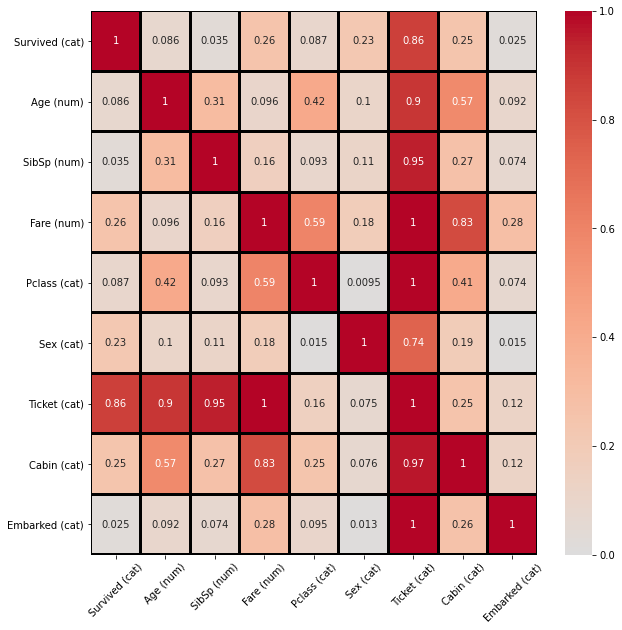

In [154]:
dataframe = train_df
numerical_vars = ['Age', 'SibSp', 'Fare']
categorical_vars = ['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']
dataframe[categorical_vars] = dataframe[categorical_vars].astype("category")
for c in categorical_vars:
    if ("Unknown" not in dataframe[c].cat.categories):
        dataframe.loc[:, c] = dataframe[c].cat.add_categories("Unknown").fillna("Unknown")
target = 'Survived'
df_corr, df_corr_ordered, (fig,ax) =  eda.associations(dataframe, numerical_vars, categorical_vars, target, target_type='categorical')
 

In [148]:
df_corr

,Survived (cat),Age (num),SibSp (num),Fare (num),Pclass (cat),Sex (cat),Ticket (cat),Cabin (cat),Embarked (cat)
Survived (cat),1.000000,0.085511,0.035322,0.257307,0.087260,0.226562,0.859717,0.248135,0.025031
Age (num),0.085511,1.000000,0.308247,0.096067,0.415230,0.103377,0.897794,0.572696,0.092032
SibSp (num),0.035322,0.308247,1.000000,0.159651,0.092652,0.114631,0.947841,0.265690,0.073556
Fare (num),0.257307,0.096067,0.159651,1.000000,0.594217,0.182333,1.000000,0.827625,0.284937
Pclass (cat),0.087260,0.415230,0.092652,0.594217,1.000000,0.009525,1.000000,0.411544,0.074002
Sex (cat),0.226562,0.103377,0.114631,0.182333,0.014644,1.000000,0.740743,0.194766,0.014929
Ticket (cat),0.859717,0.897794,0.947841,1.000000,0.155889,0.075110,1.000000,0.250765,0.120444
Cabin (cat),0.248135,0.572696,0.265690,0.827625,0.247437,0.076168,0.967164,1.000000,0.122453
Embarked (cat),0.025031,0.092032,0.073556,0.284937,0.095323,0.012509,0.995224,0.262345,1.000000


In [142]:
eda.theil_U(dataframe, "Cabin", "Ticket")

/home/edoardo/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


1.77403894736768

In [107]:
import dython.nominal as dy
import scipy.stats as ss
from collections import Counter

In [98]:
dy.theils_u(dataframe["Cabin"], dataframe["Ticket"])

0.9671637833438991

In [117]:
dy.conditional_entropy(dataframe["Cabin"], dataframe["Ticket"])

0.0544864250347395

In [108]:
x = dataframe["Cabin"]
x_counter = Counter(x)
total_occurrences = sum(x_counter.values())
p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
s_x = ss.entropy(p_x)
s_x

1.6593393083431214

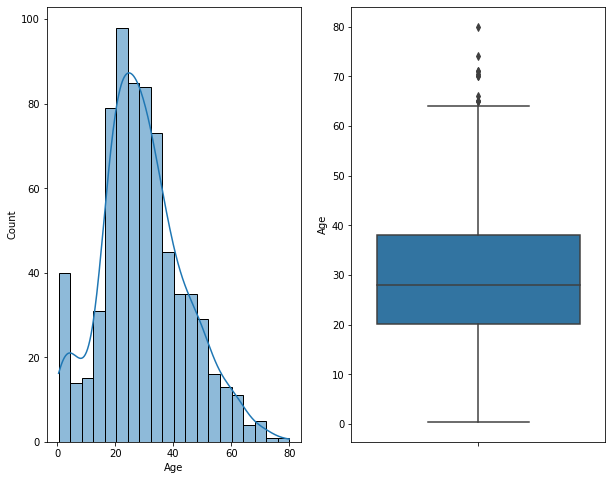

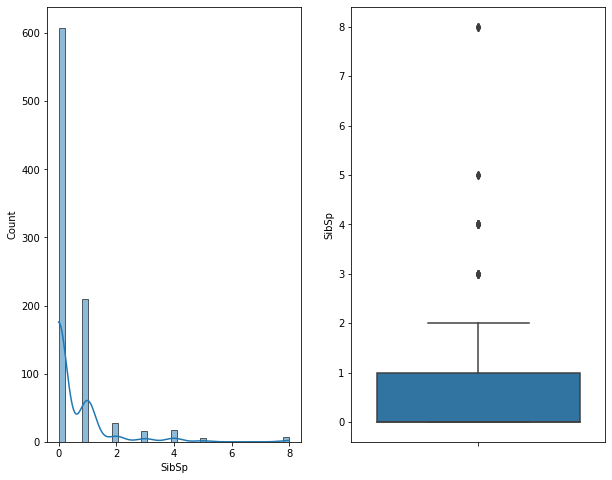

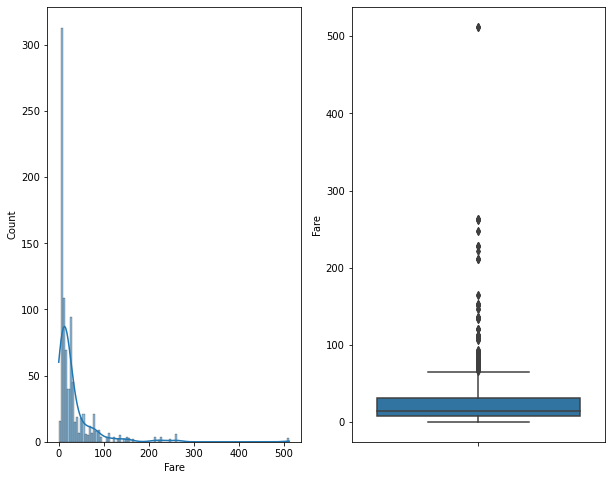

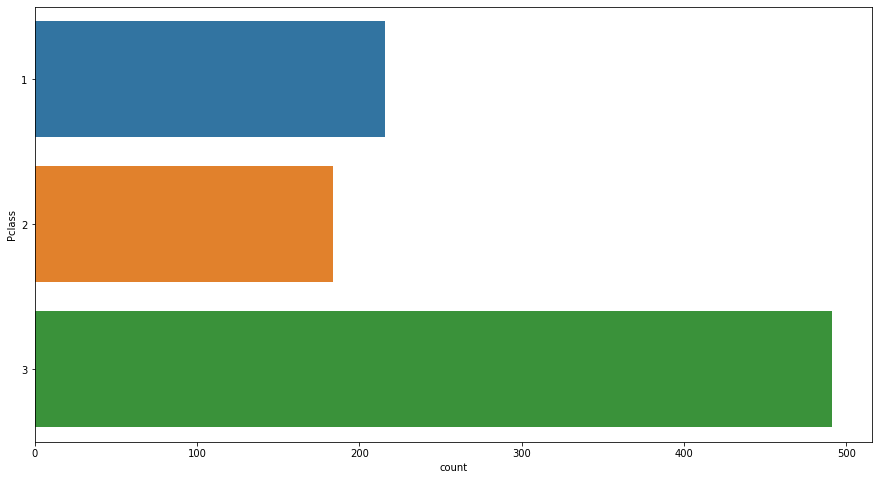

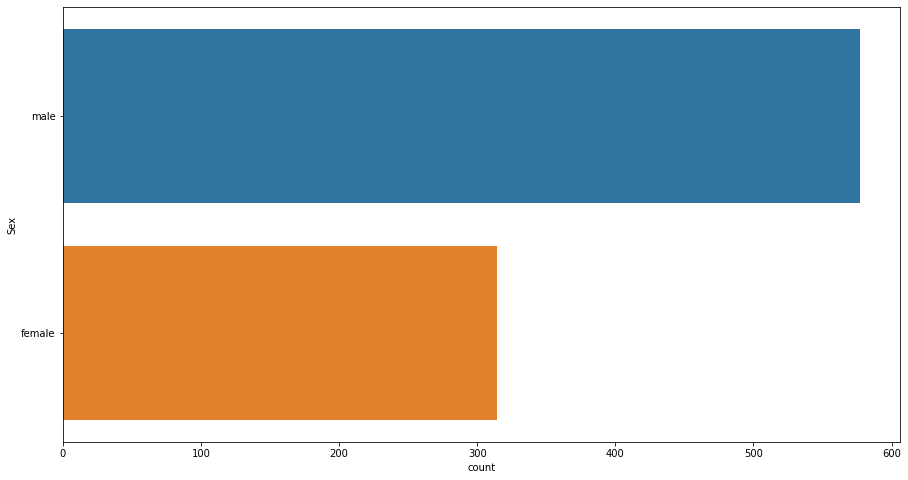

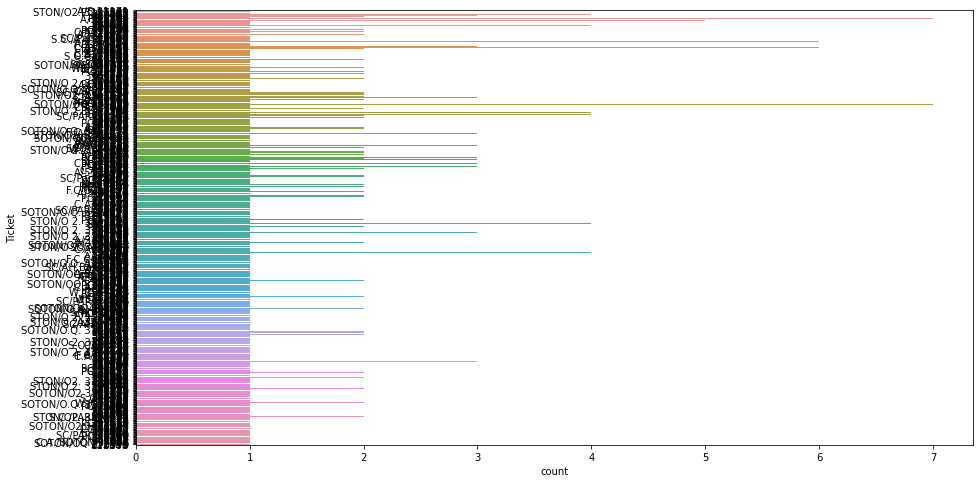

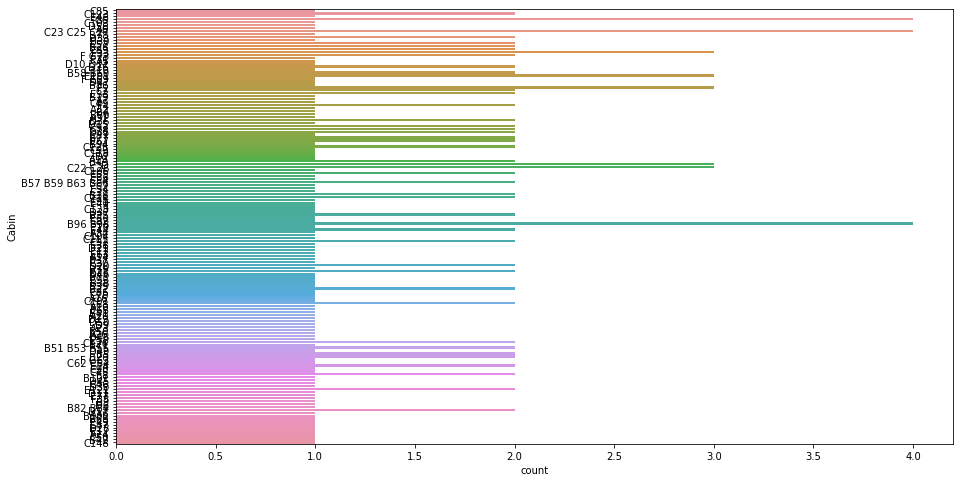

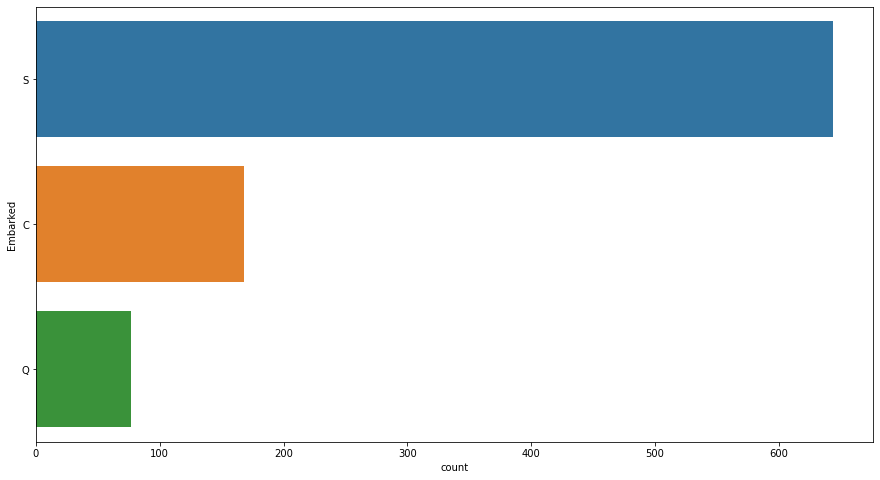

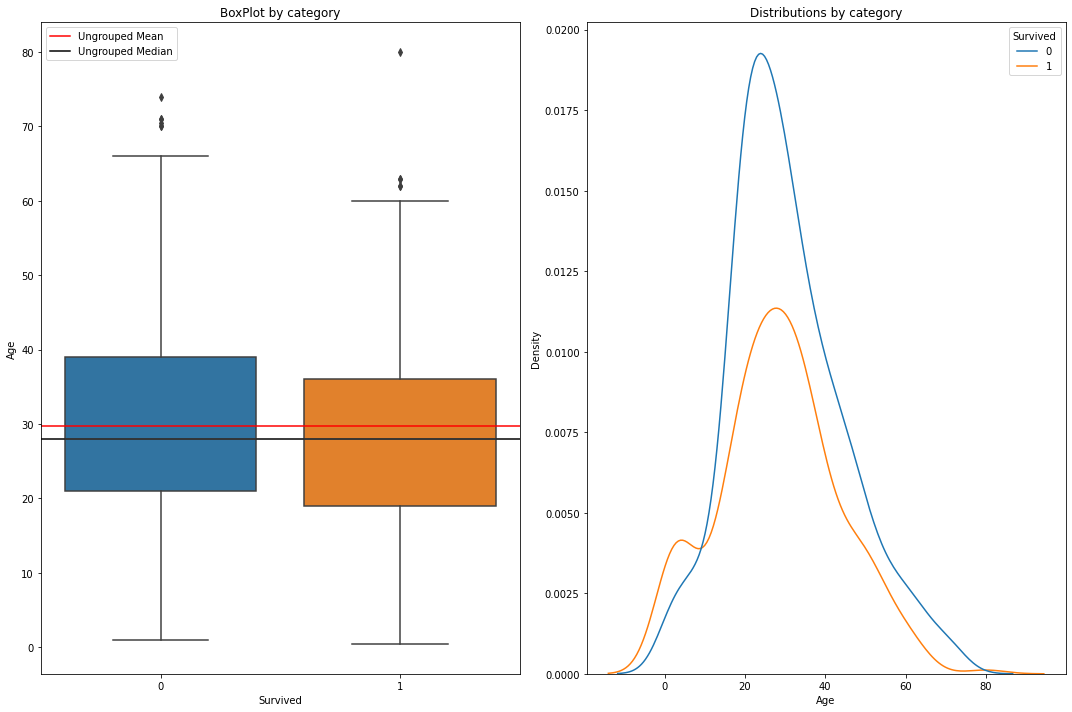

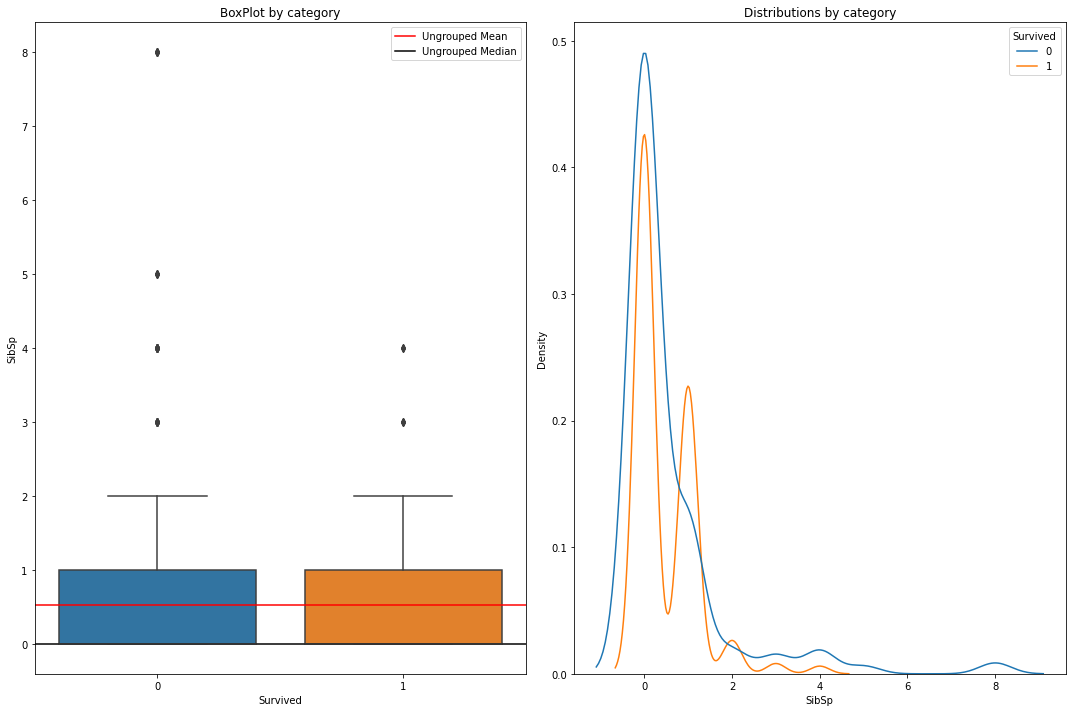

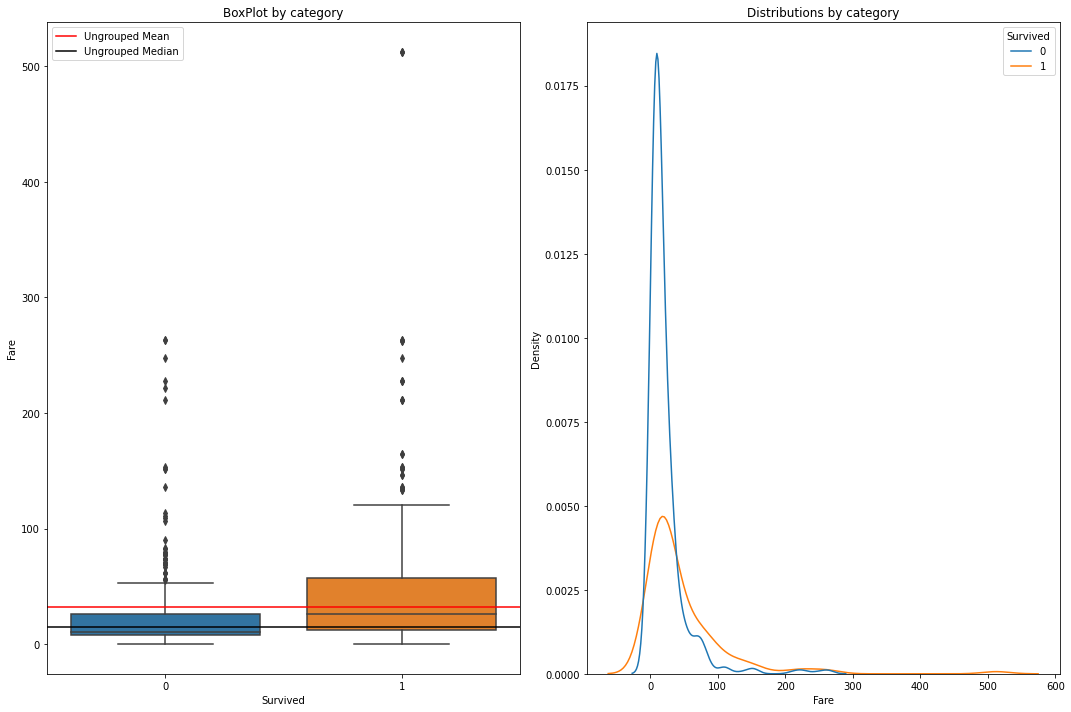

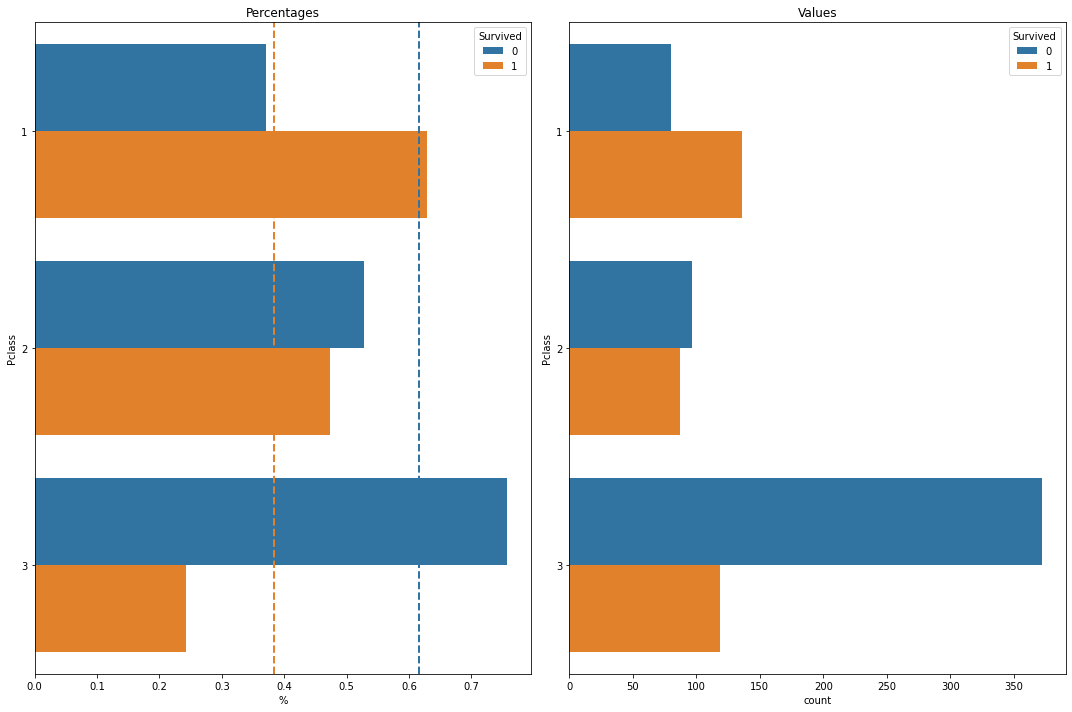

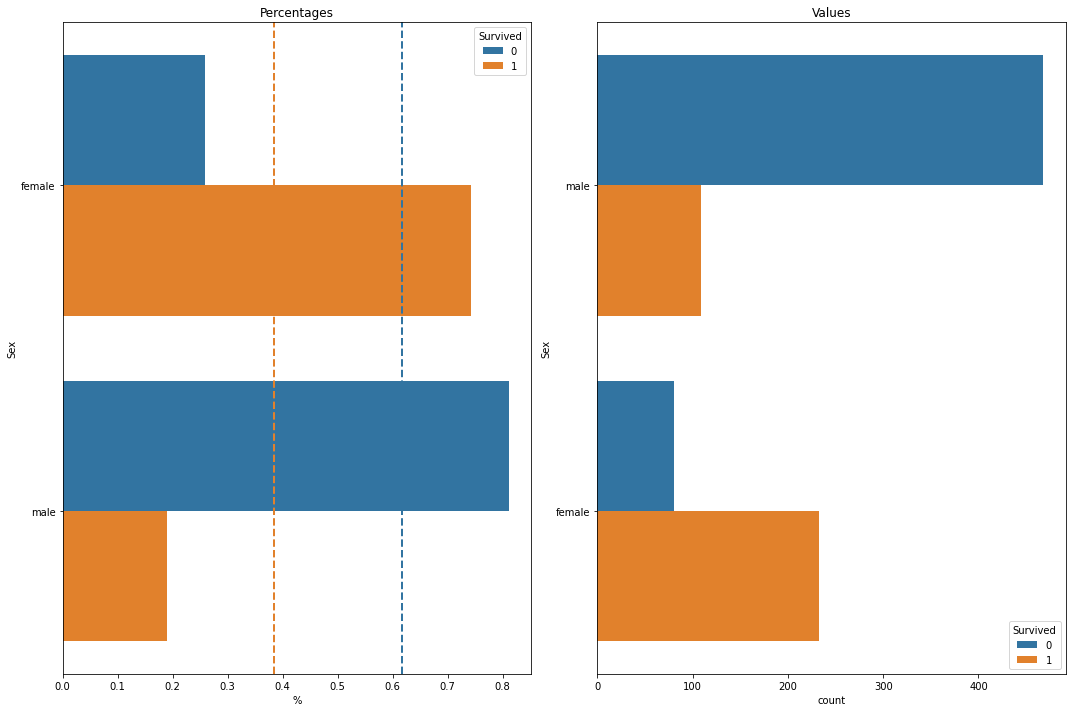

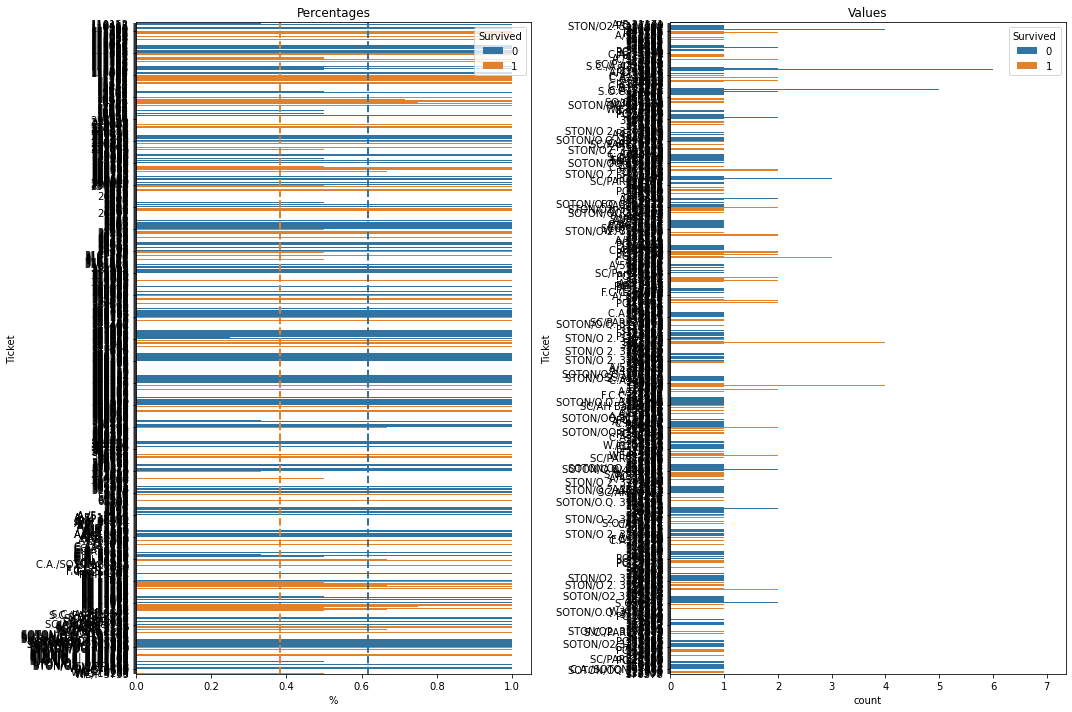

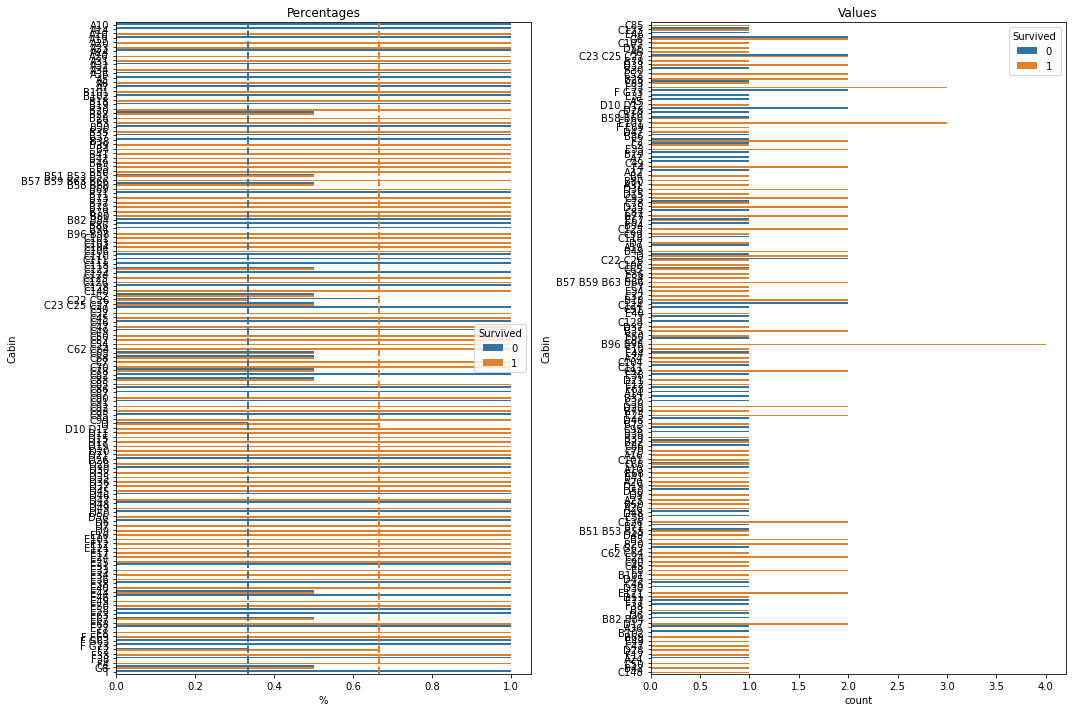

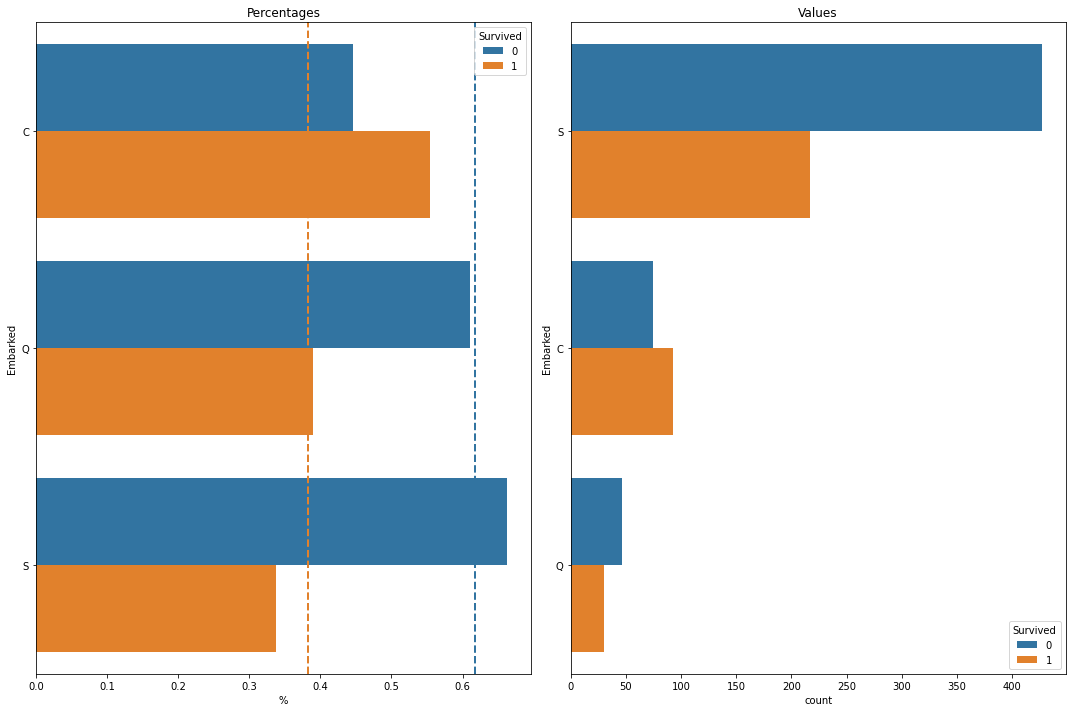

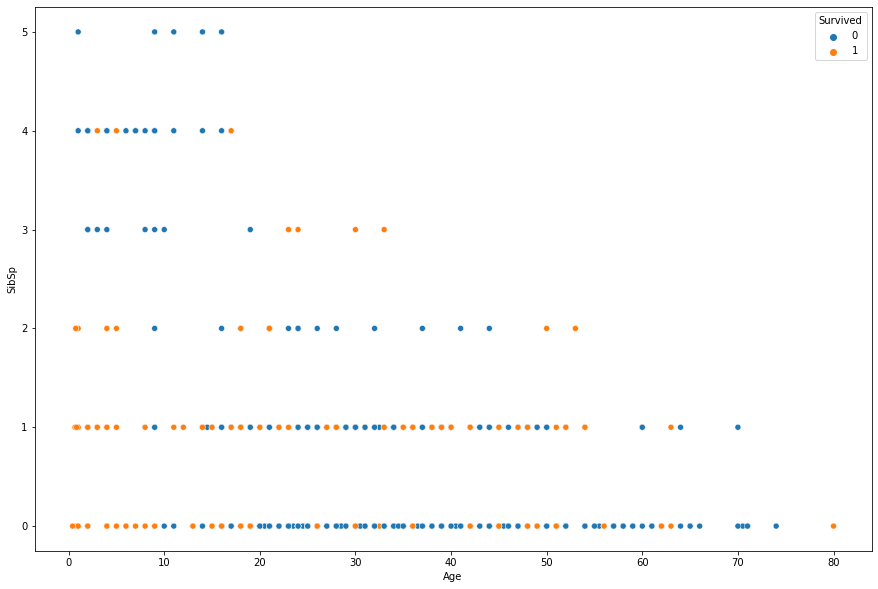

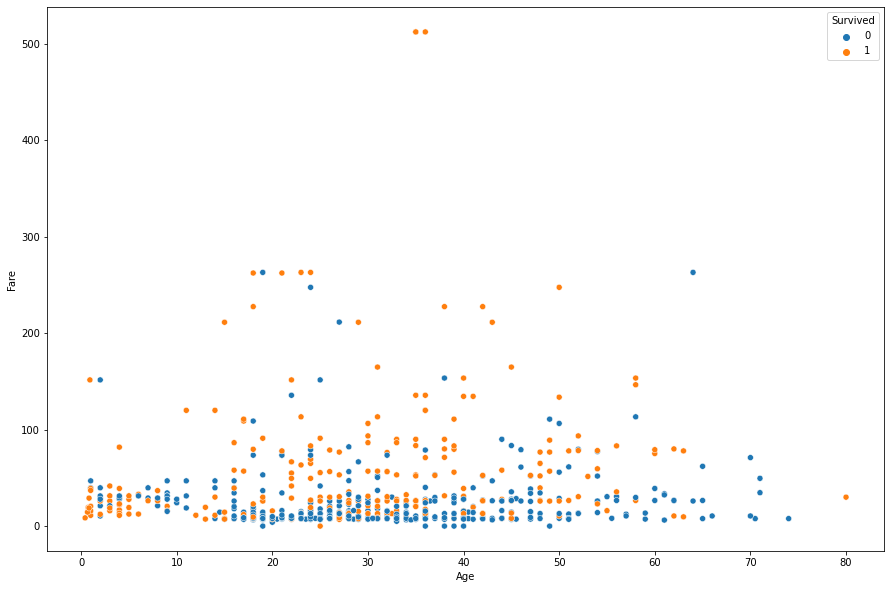

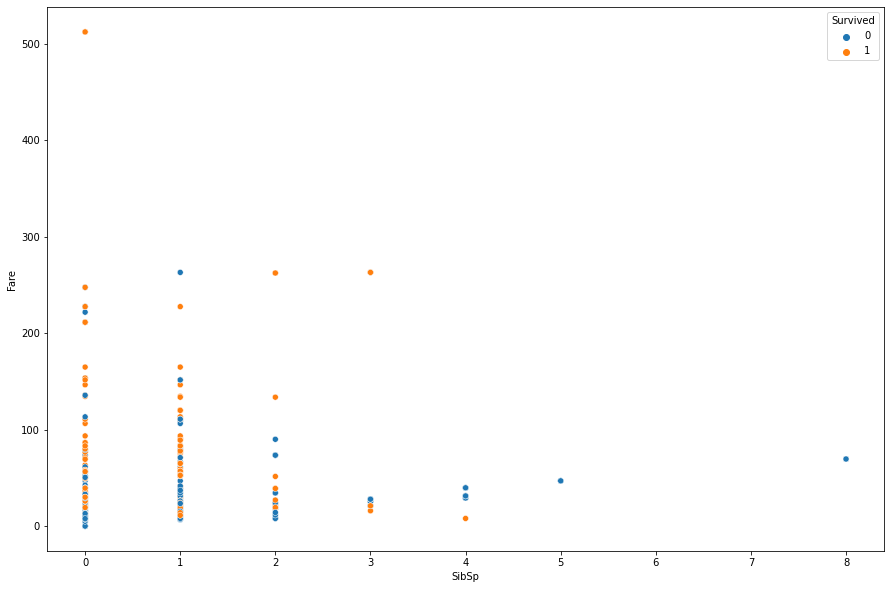

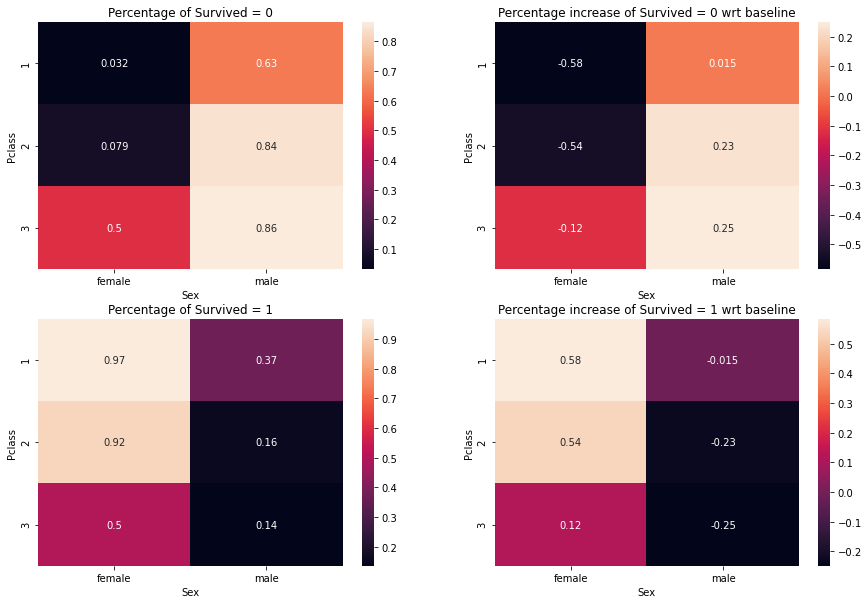

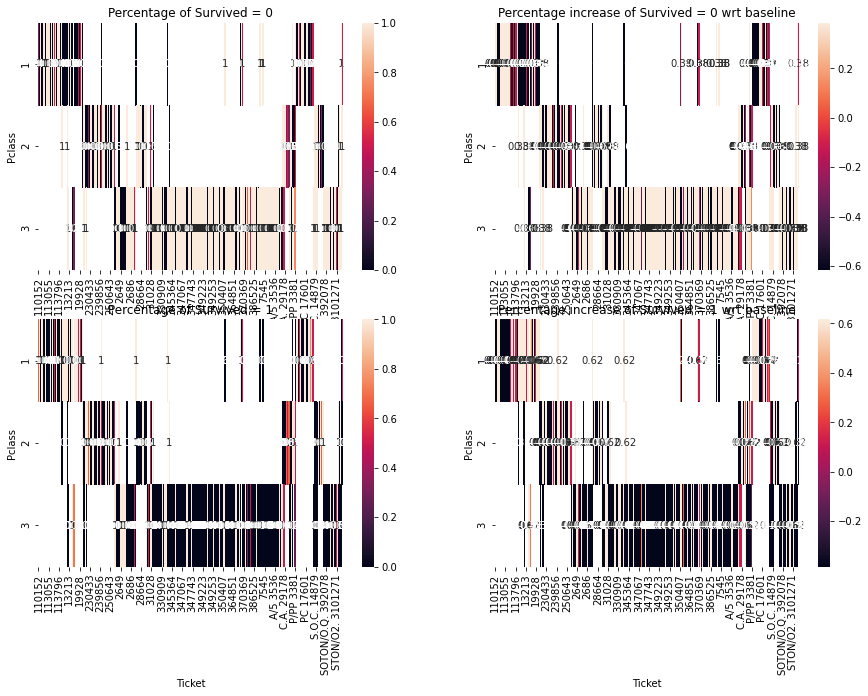

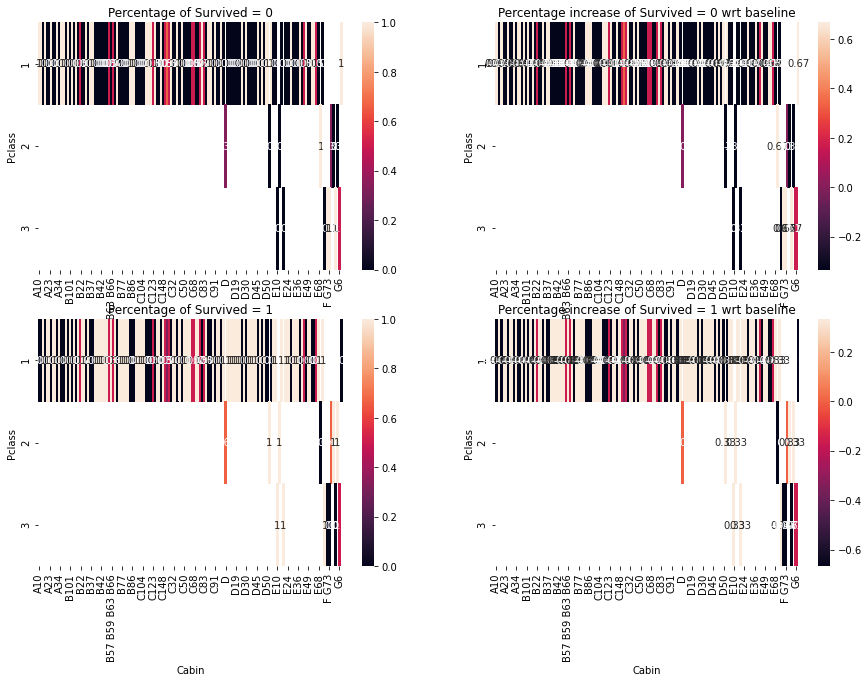

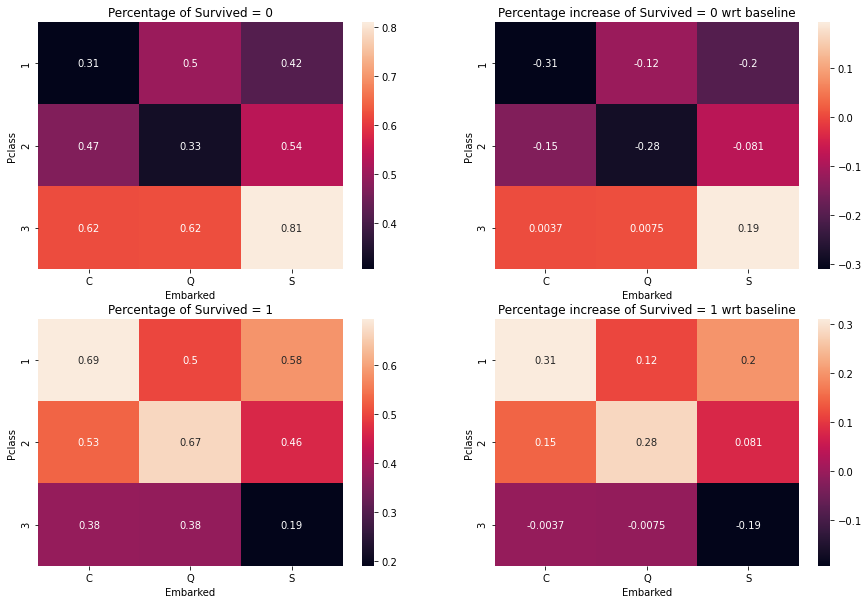

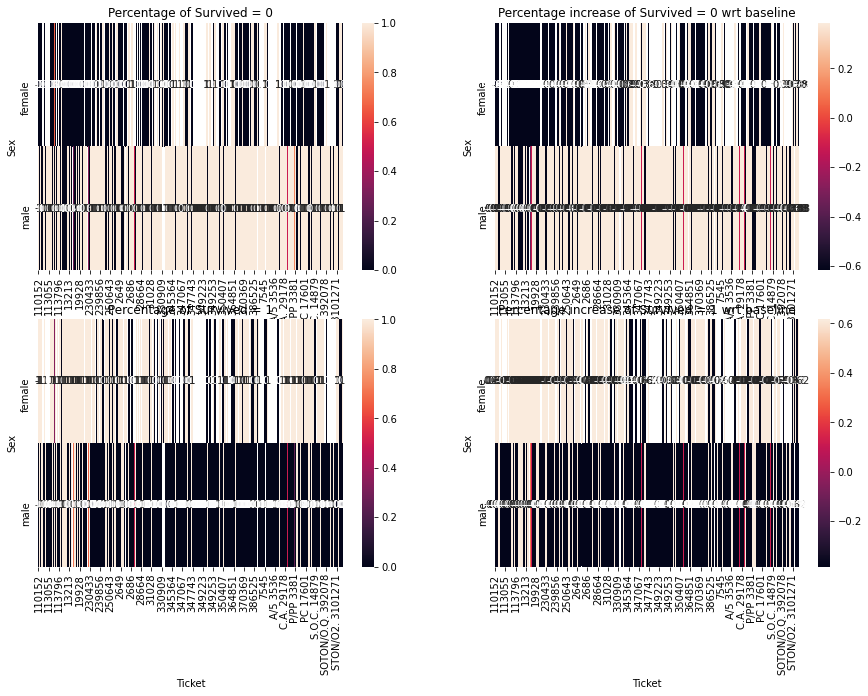

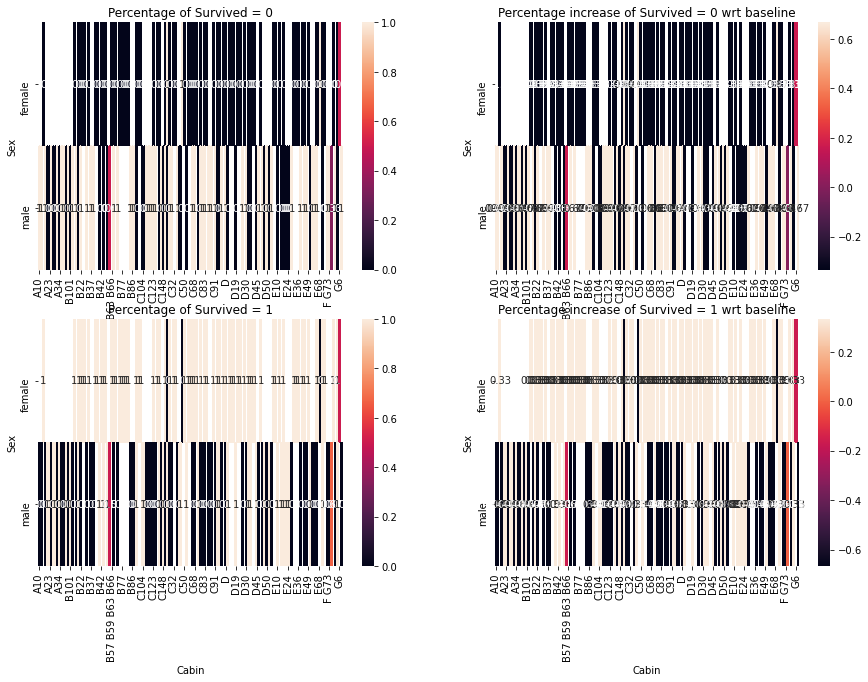

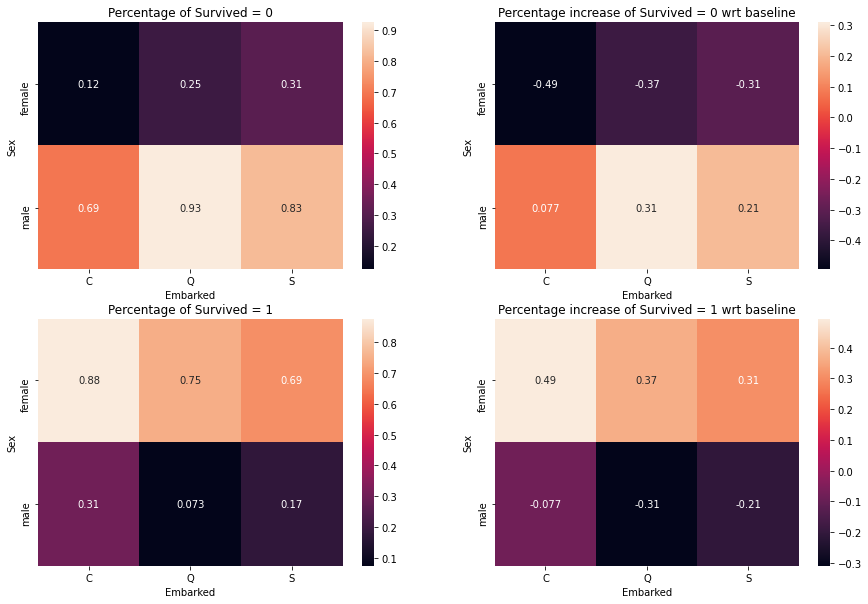

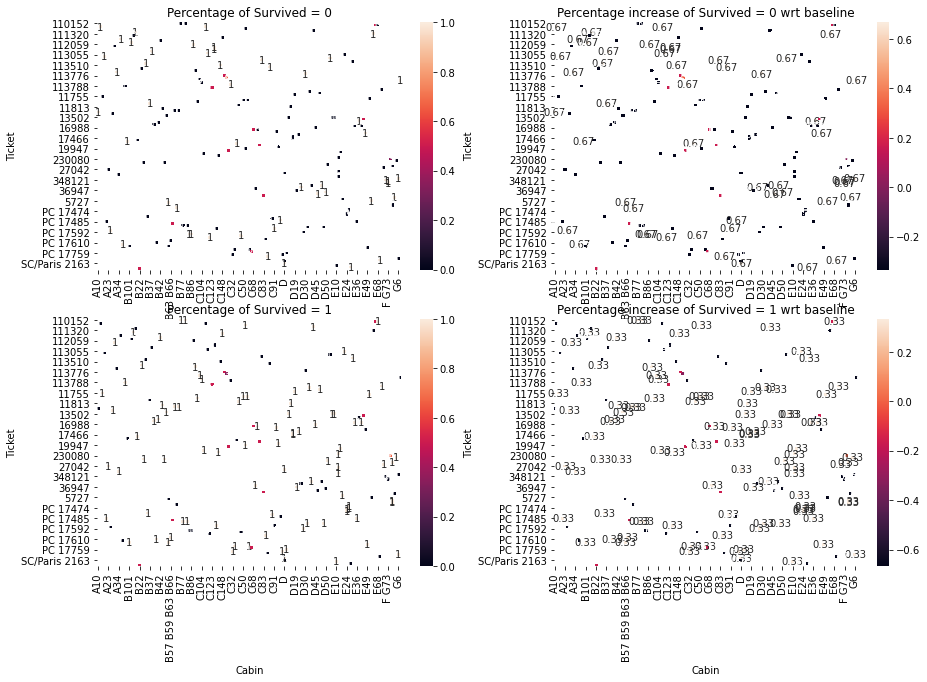

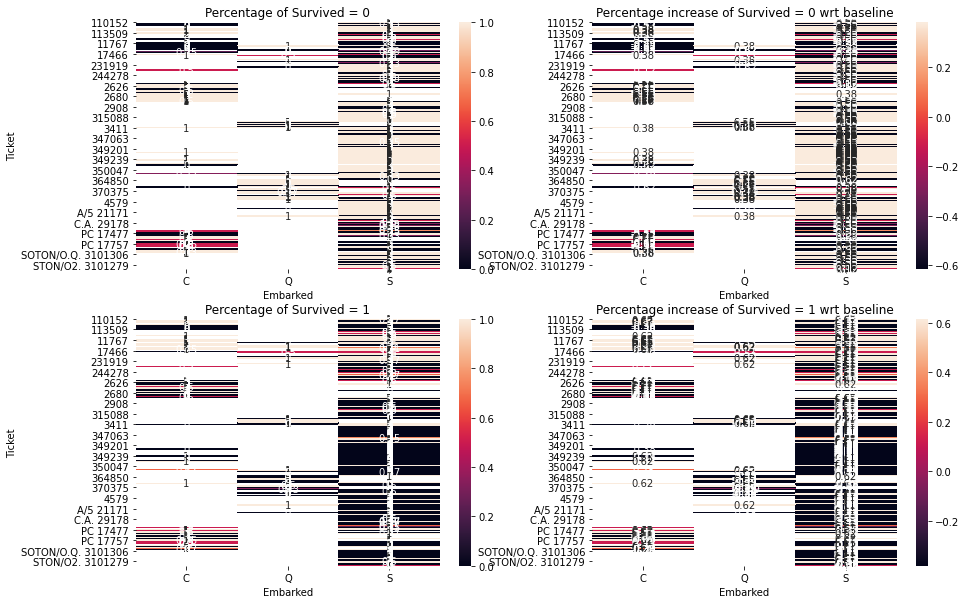

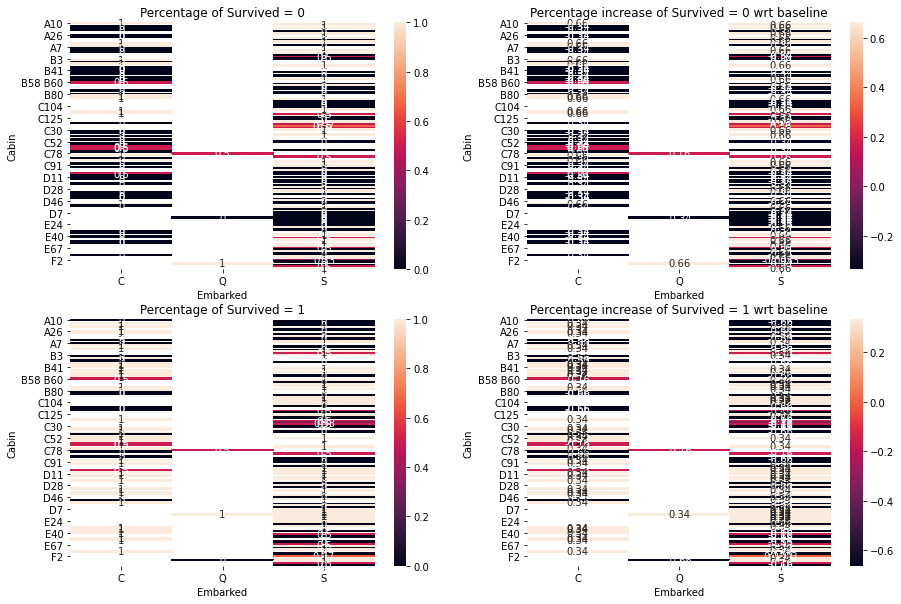

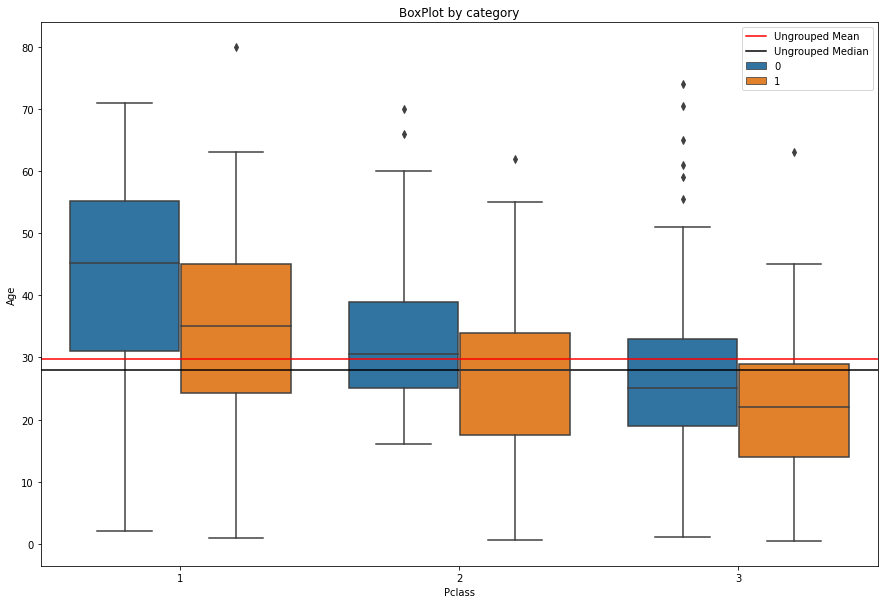

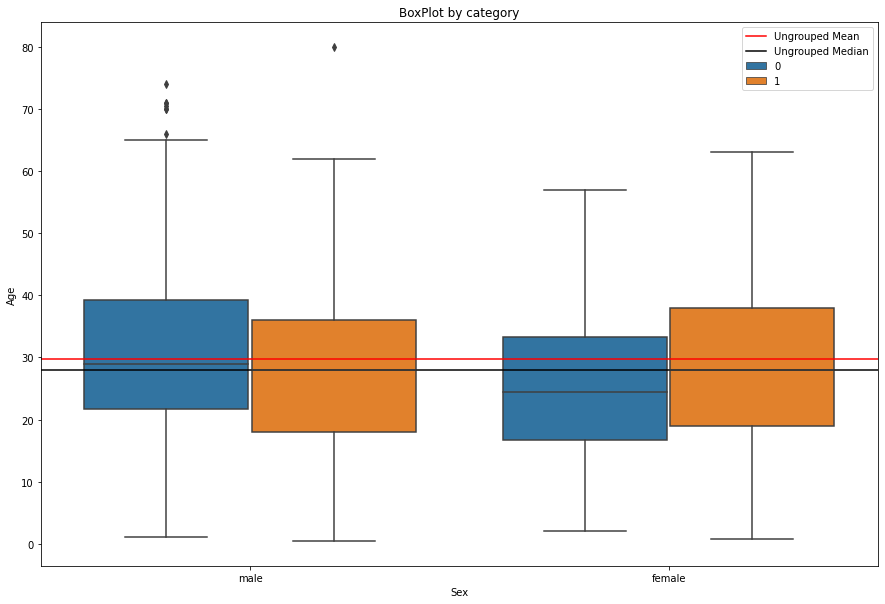

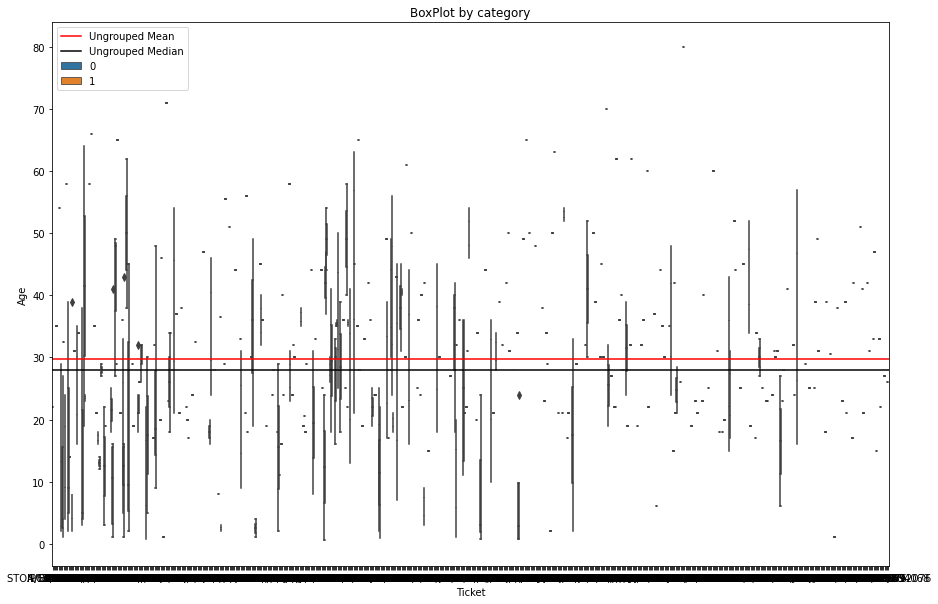

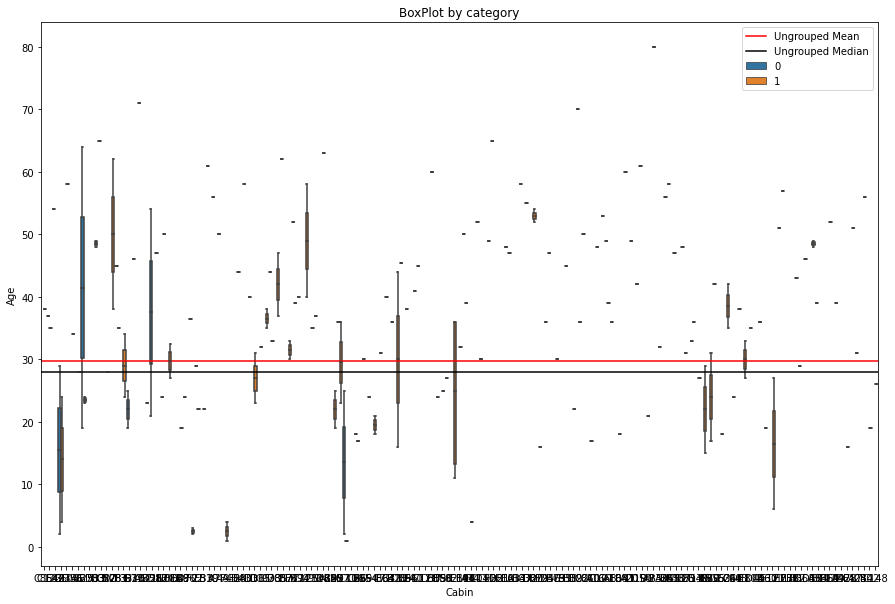

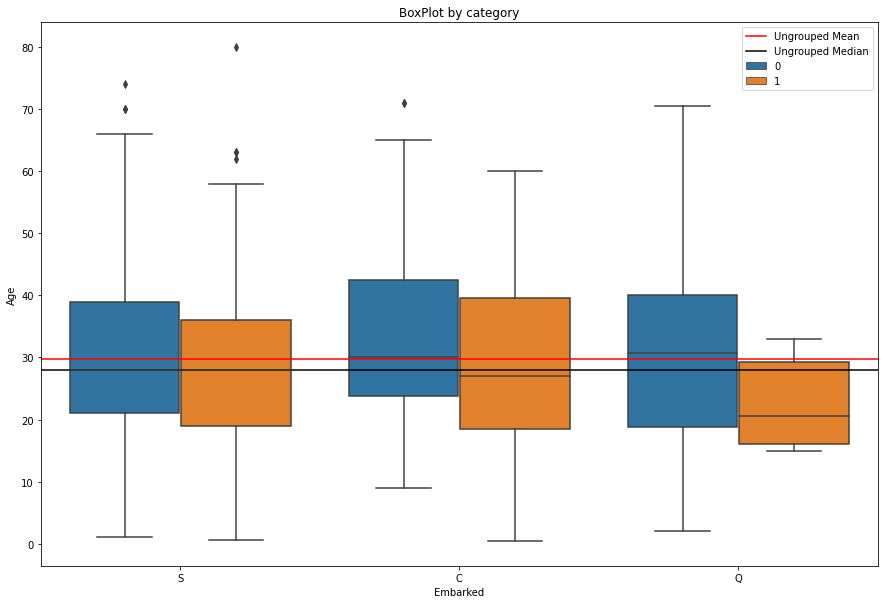

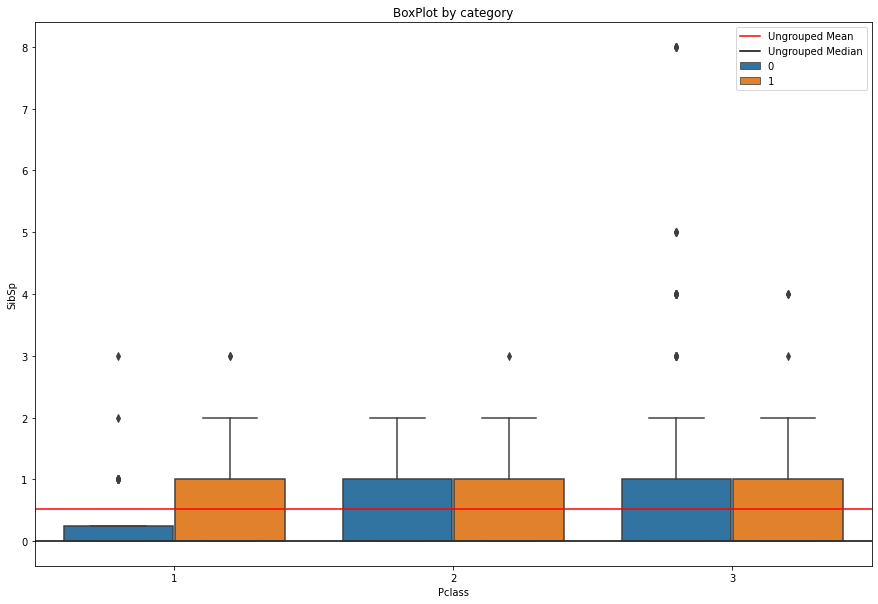

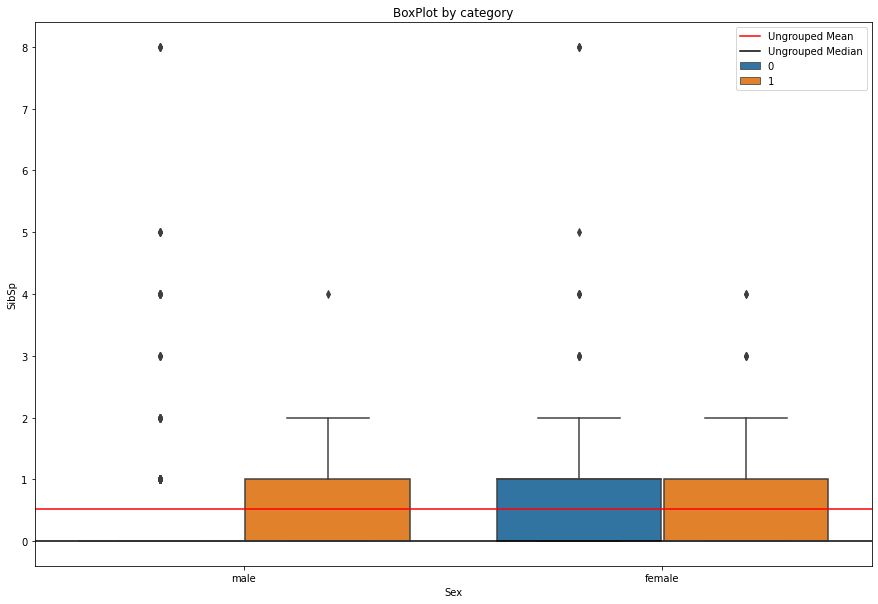

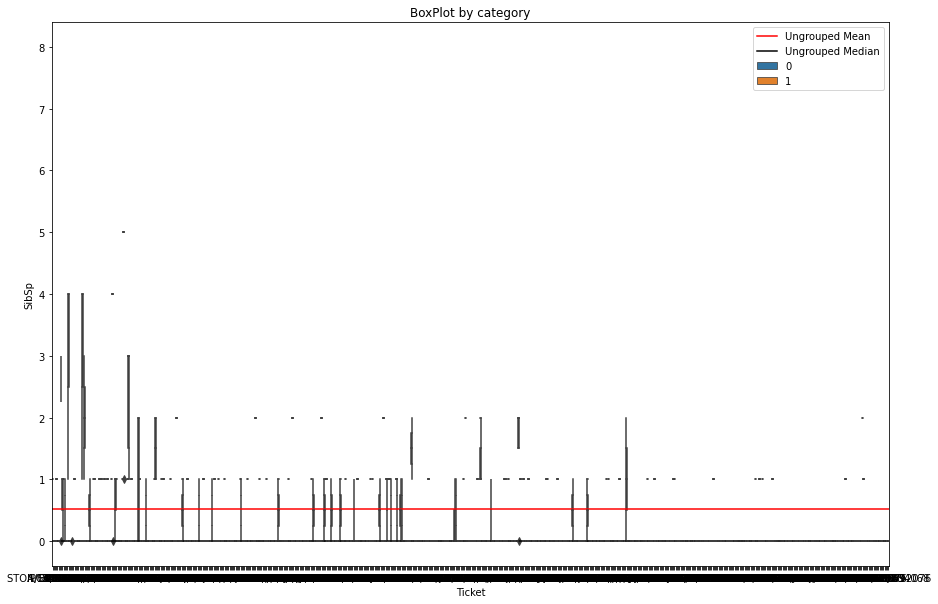

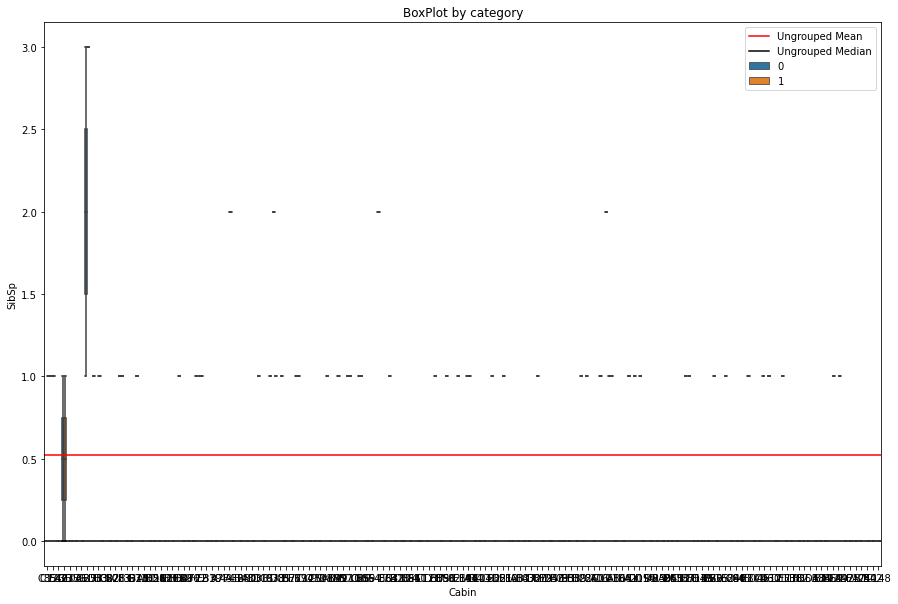

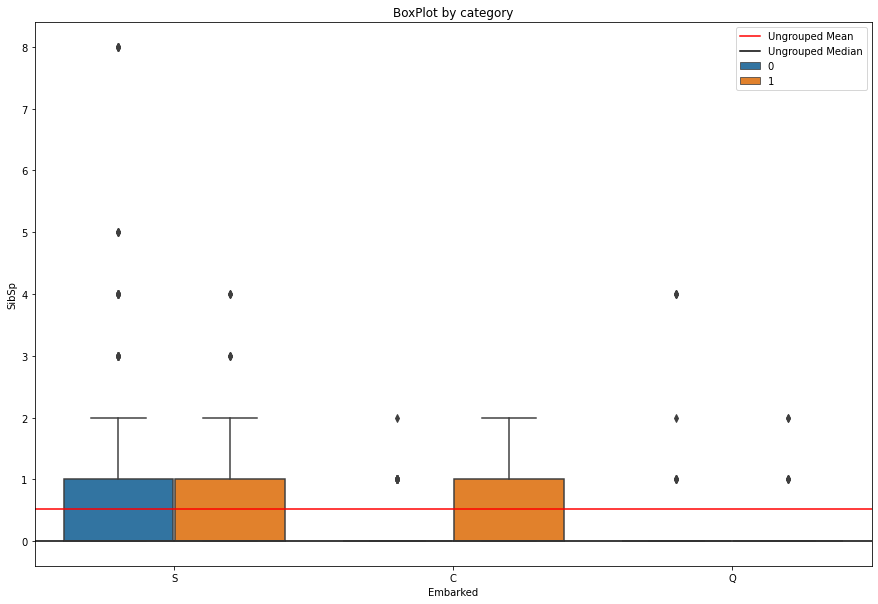

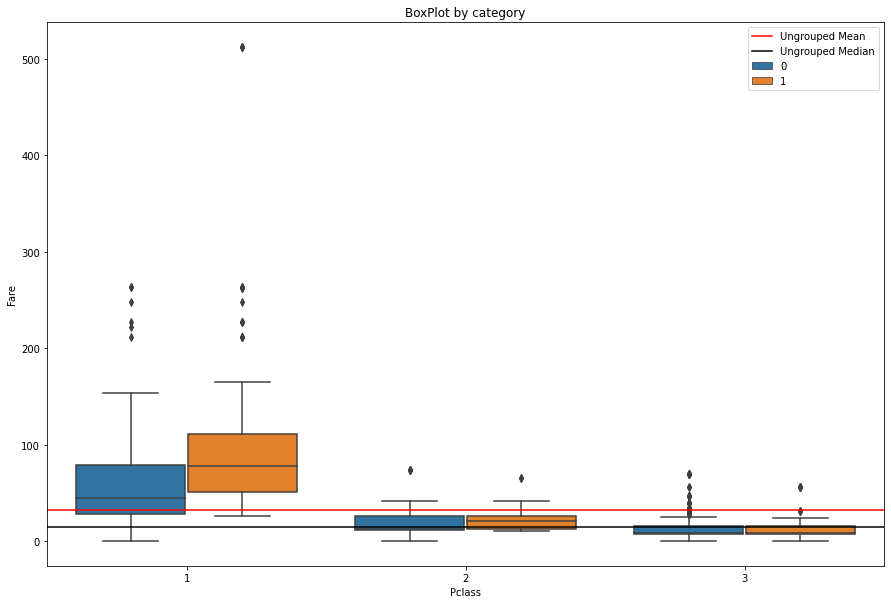

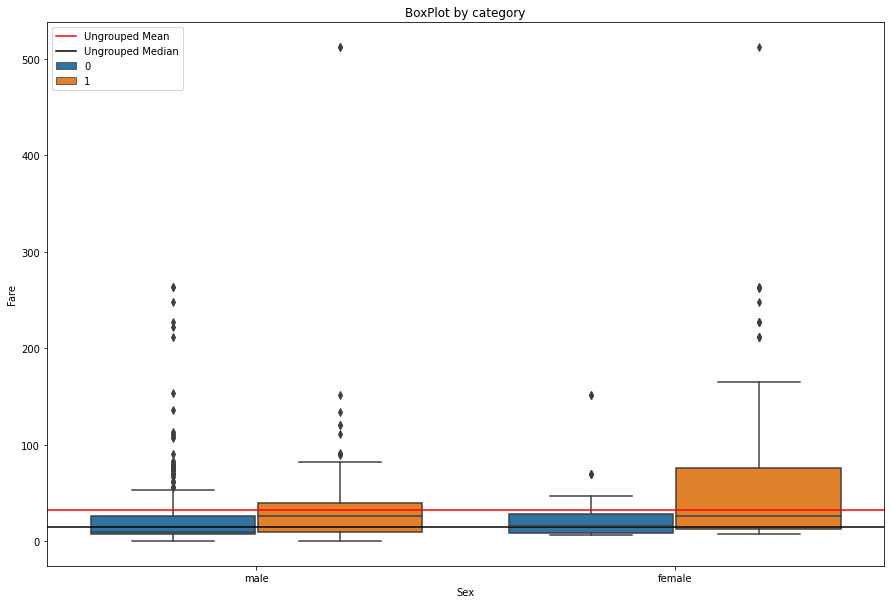

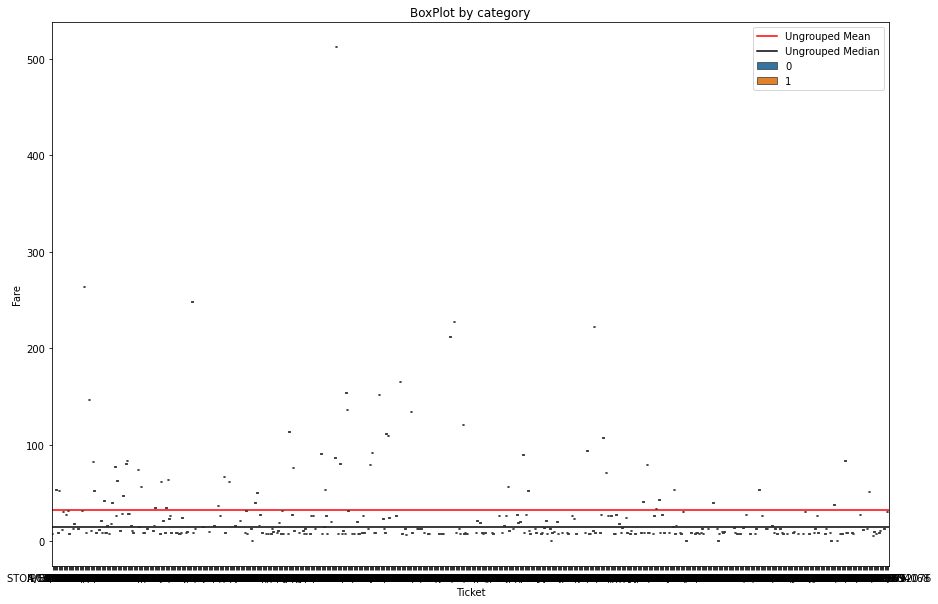

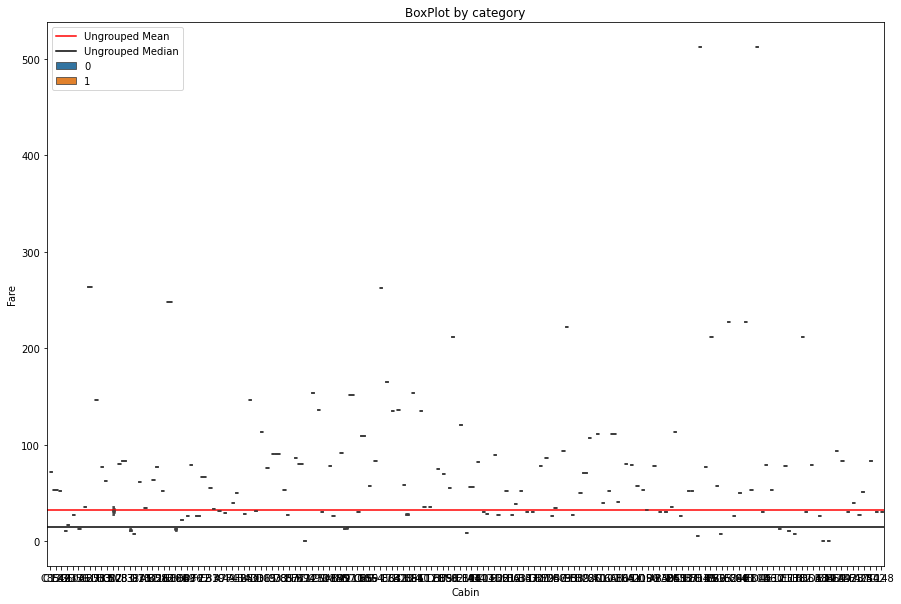

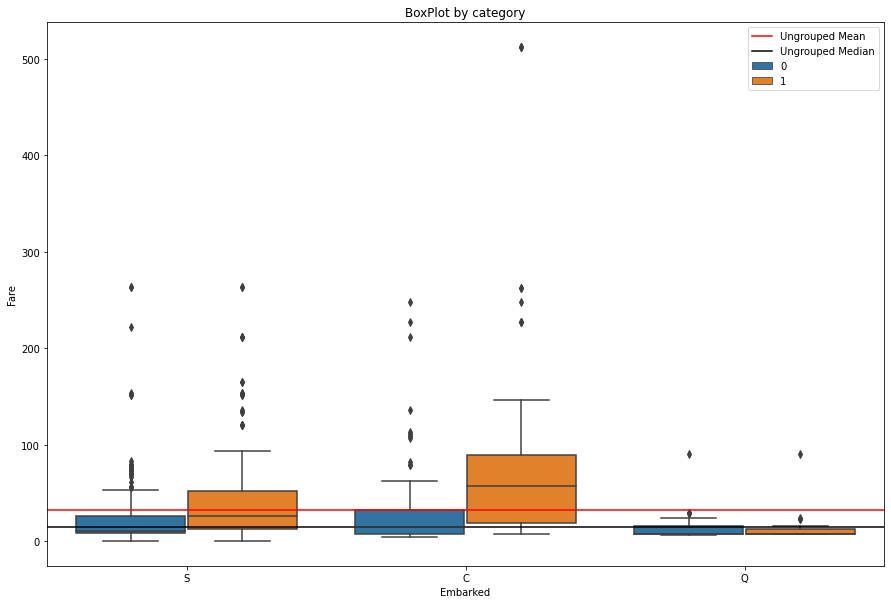

In [22]:
dataframe = train_df
numerical_vars = ['Age', 'SibSp', 'Fare']
categorical_vars = ['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']
target = 'Survived'
summary_dict = eda.summaryEDA(dataframe, numerical_vars, categorical_vars, target, target_type='categorical');

In [35]:
summary_dict[("Age","Pclass", "Survived")]["summary"]

,Age,Age_Pclass:1_Survived:0,Age_Pclass:1_Survived:1,Age_Pclass:2_Survived:0,Age_Pclass:2_Survived:1,Age_Pclass:3_Survived:0,Age_Pclass:3_Survived:1
count,714.000000,64.000000,122.000000,90.000000,83.000000,270.000000,85.000000
mean,29.699118,43.695312,35.368197,33.544444,25.901566,26.555556,20.646118
std,14.526497,15.284243,13.760017,12.151581,14.837787,12.334882,11.995047
min,0.420000,2.000000,0.920000,16.000000,0.670000,1.000000,0.420000
25%,20.125000,31.000000,24.250000,25.000000,17.500000,19.000000,14.000000
50%,28.000000,45.250000,35.000000,30.500000,28.000000,25.000000,22.000000
75%,38.000000,55.250000,45.000000,39.000000,34.000000,33.000000,29.000000
max,80.000000,71.000000,80.000000,70.000000,62.000000,74.000000,63.000000


In [33]:
summary_dict[("Pclass","Sex", "Survived")]["summary"][1]

Survived              0         1
Pclass Sex                       
1      female  0.031915  0.968085
       male    0.631148  0.368852
2      female  0.078947  0.921053
       male    0.842593  0.157407
3      female  0.500000  0.500000
       male    0.864553  0.135447
All            0.616162  0.383838

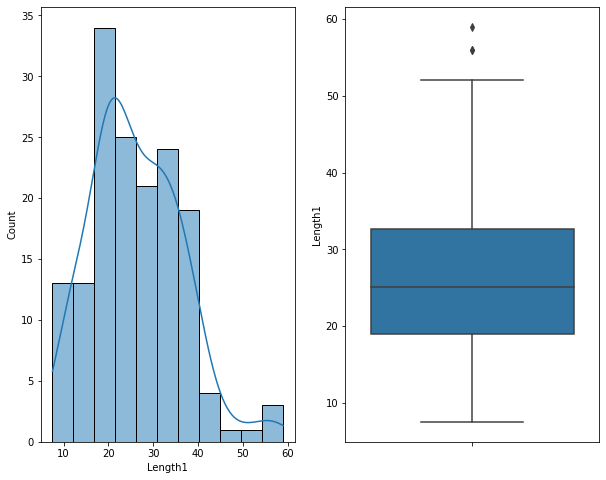

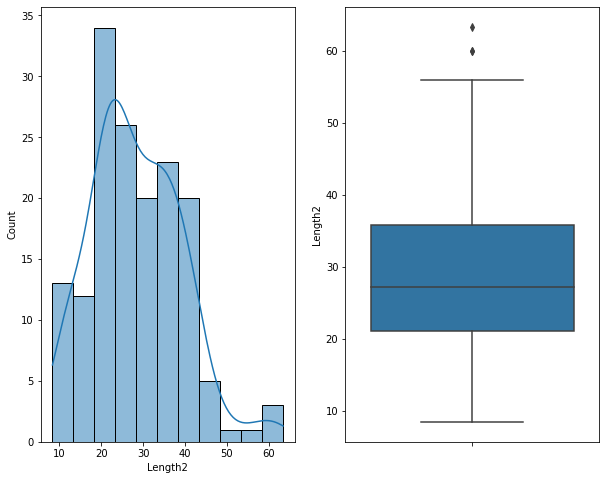

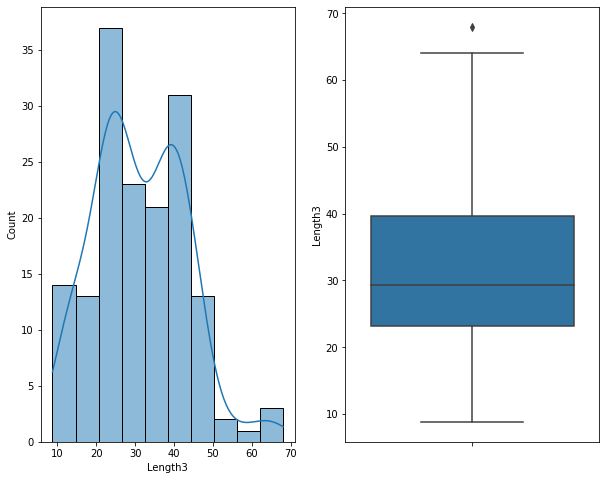

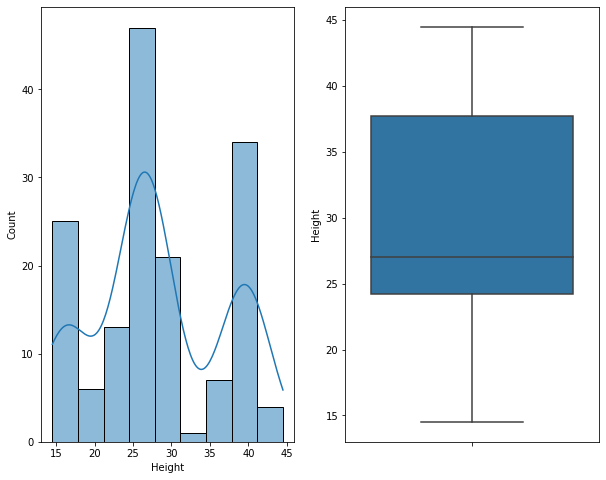

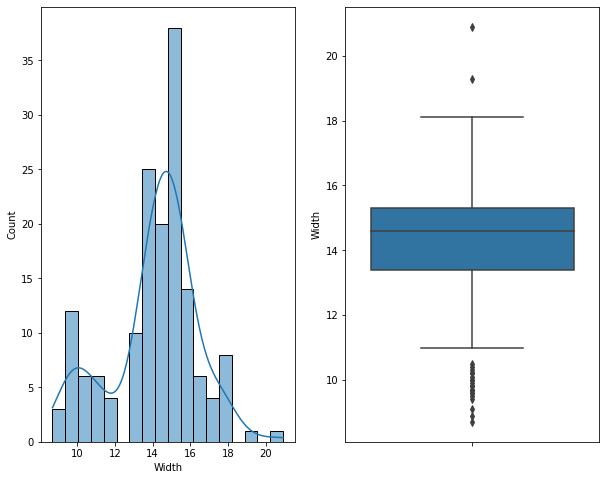

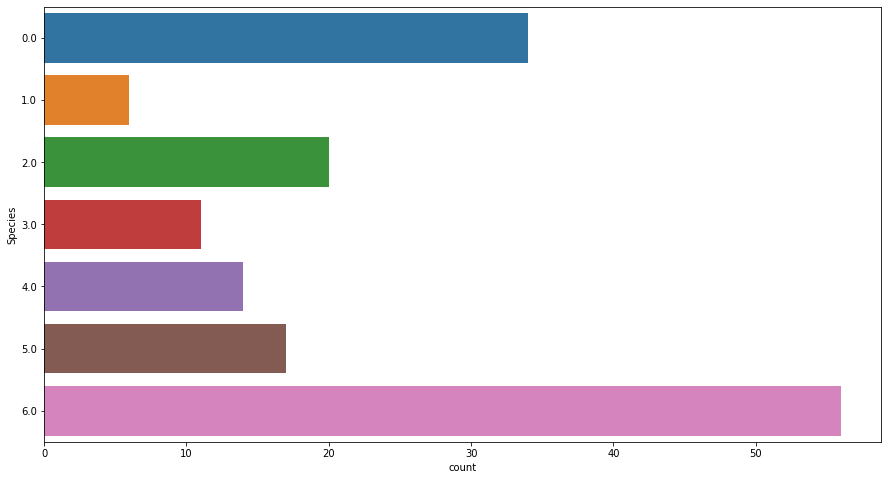

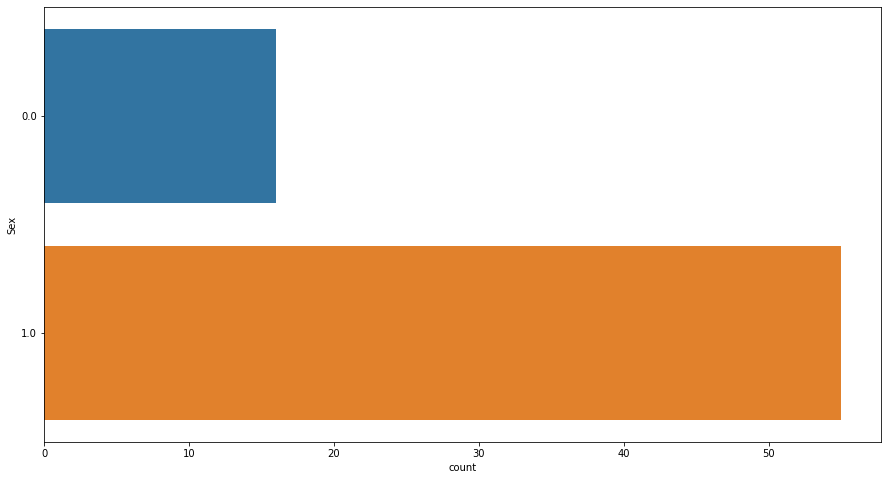

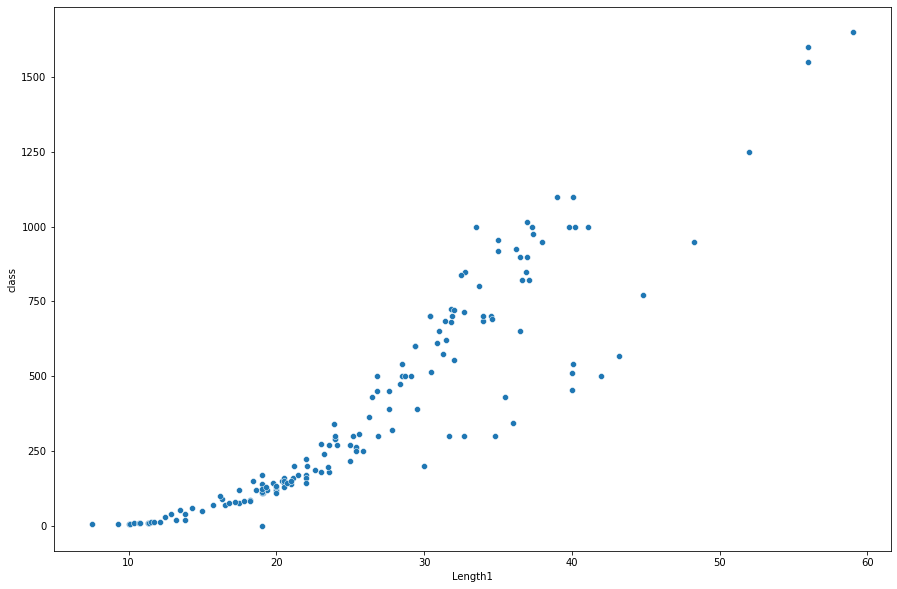

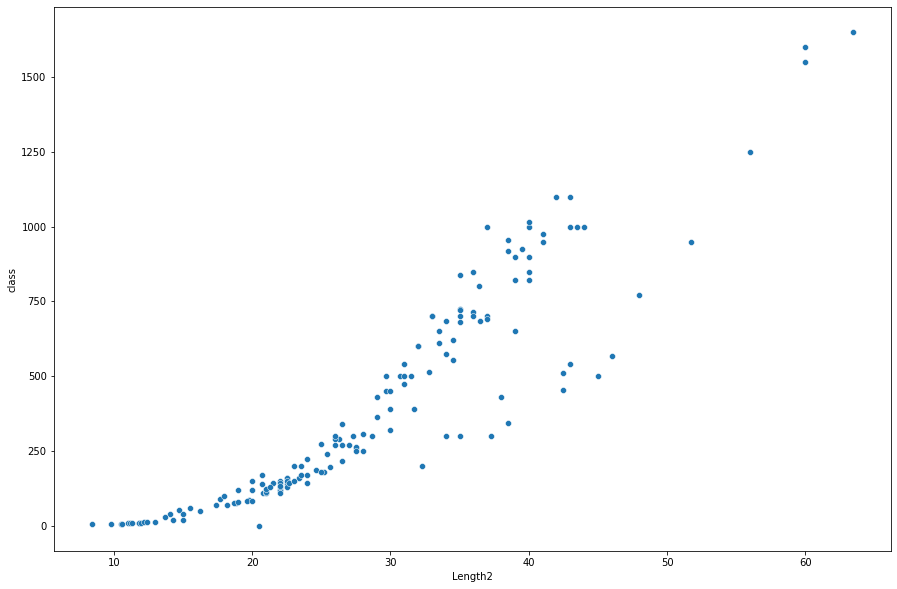

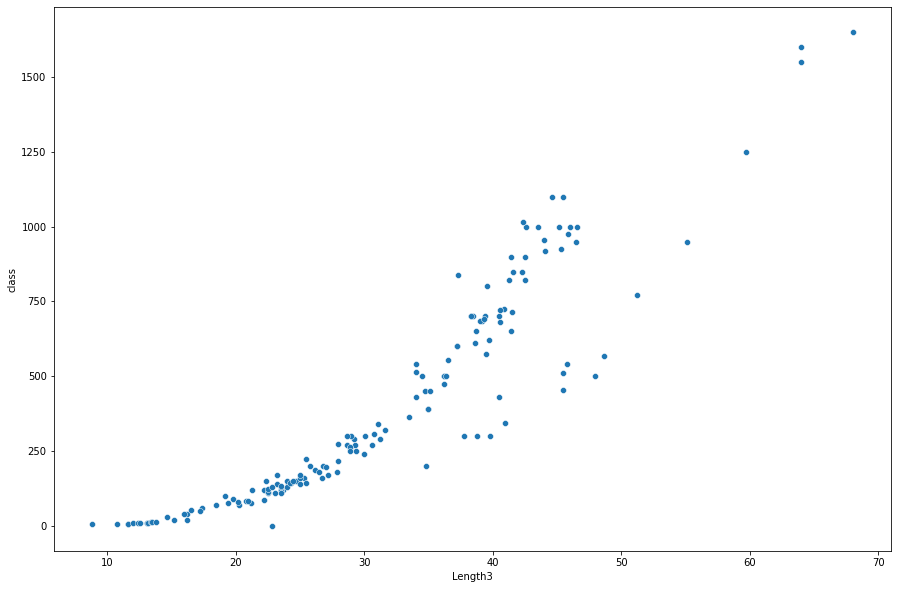

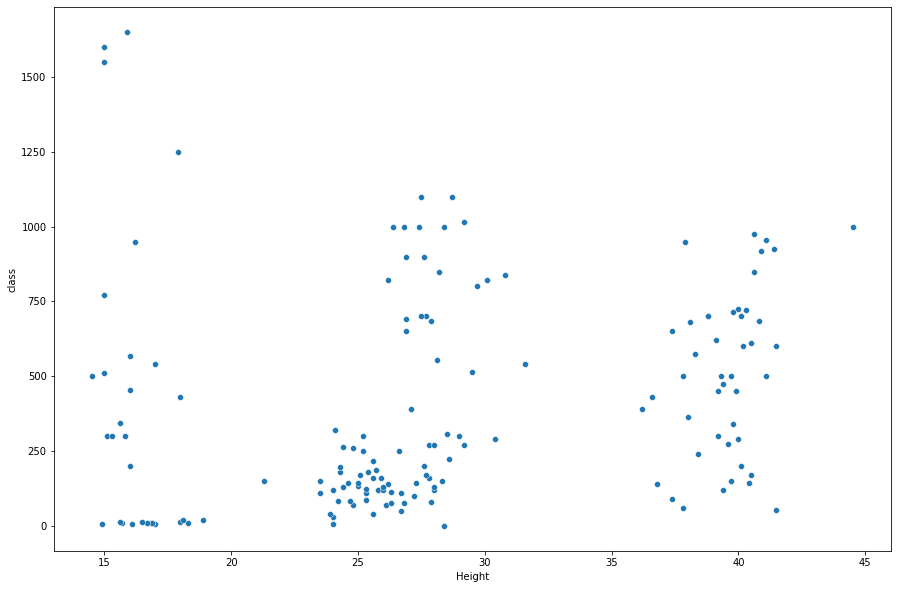

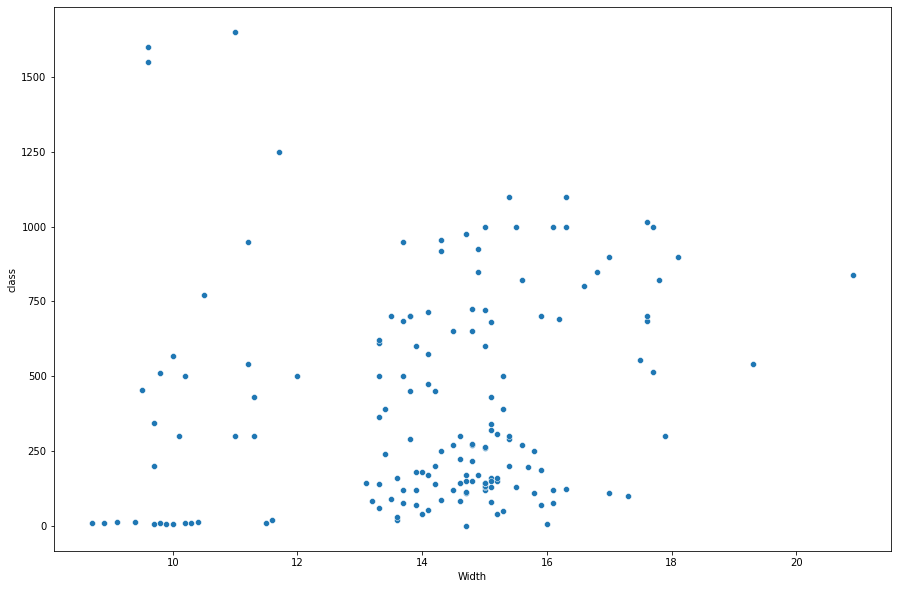

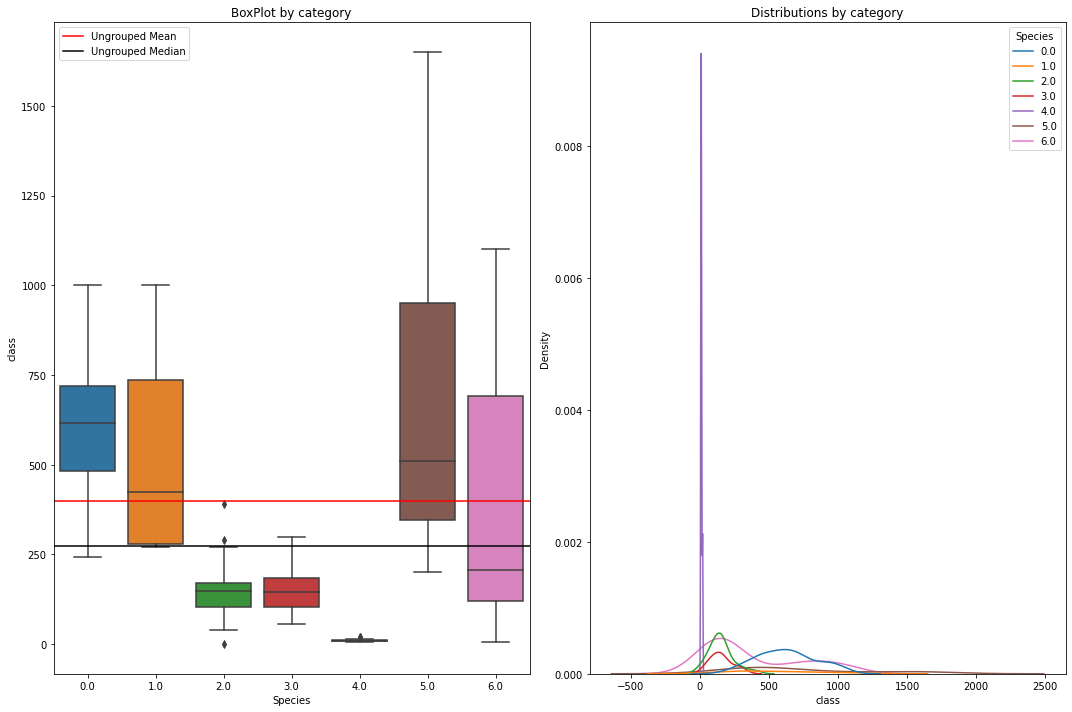

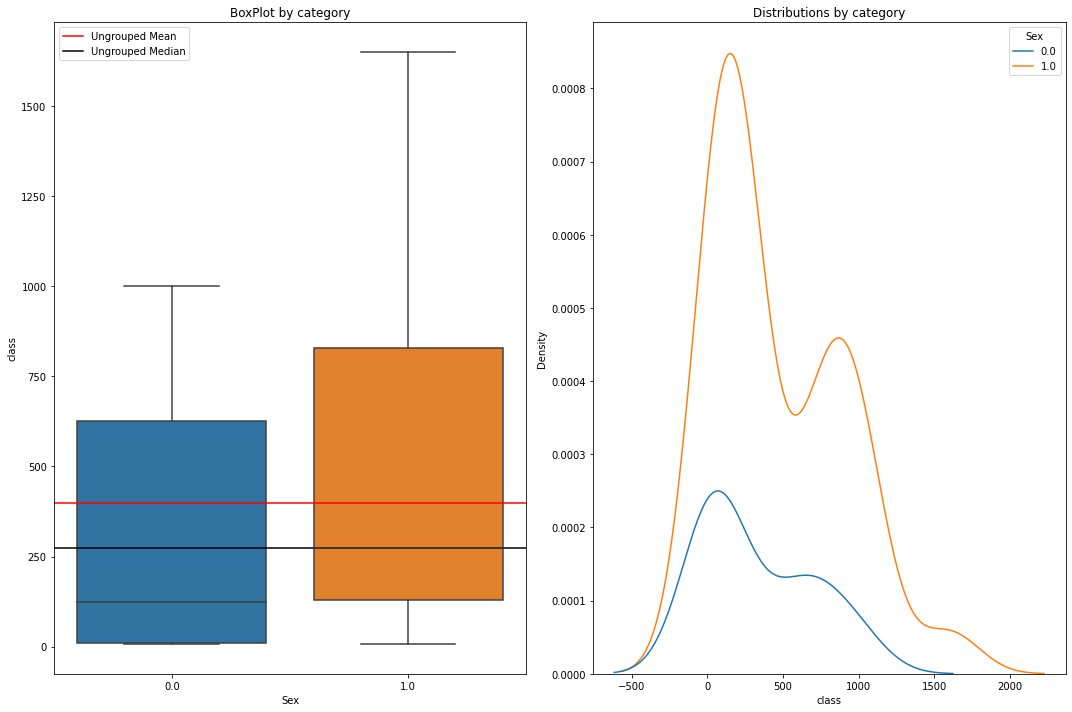

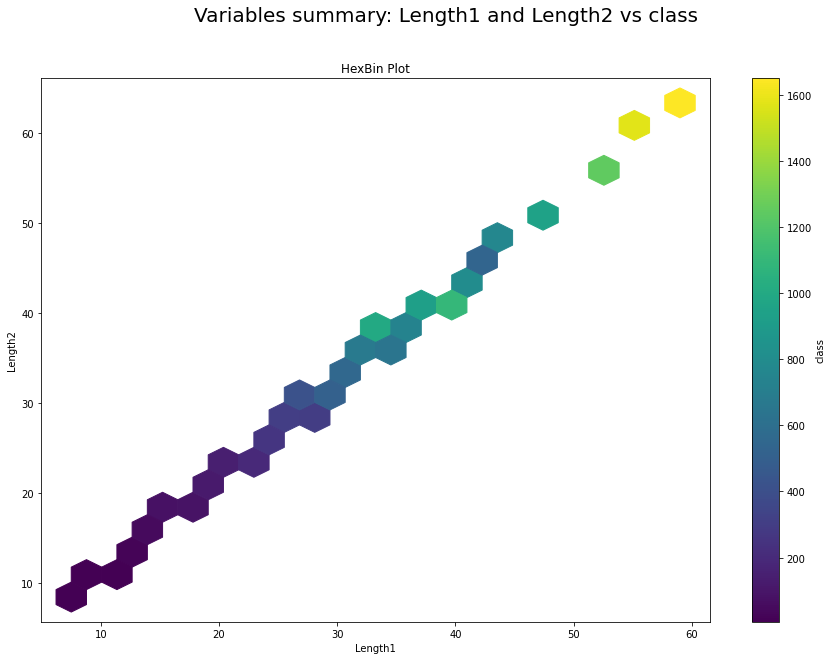

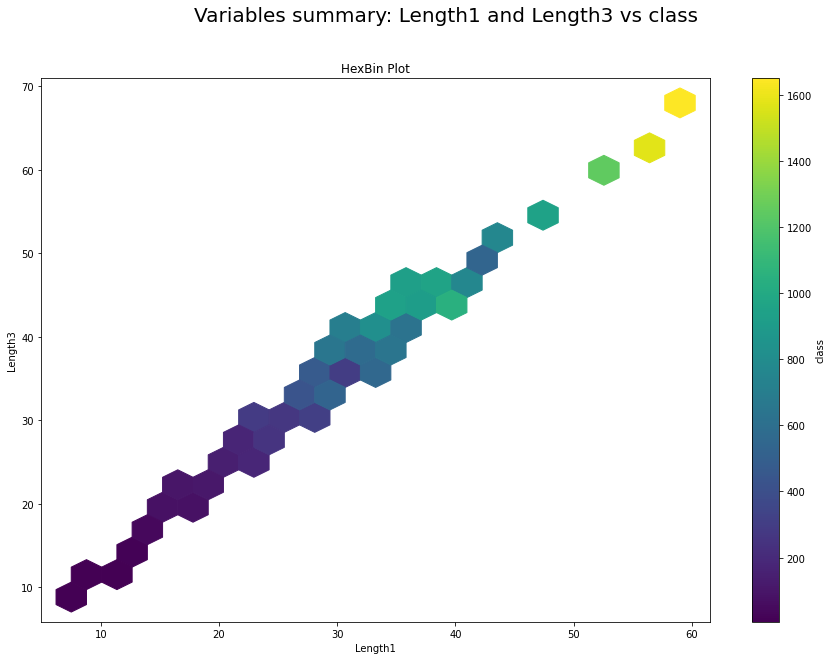

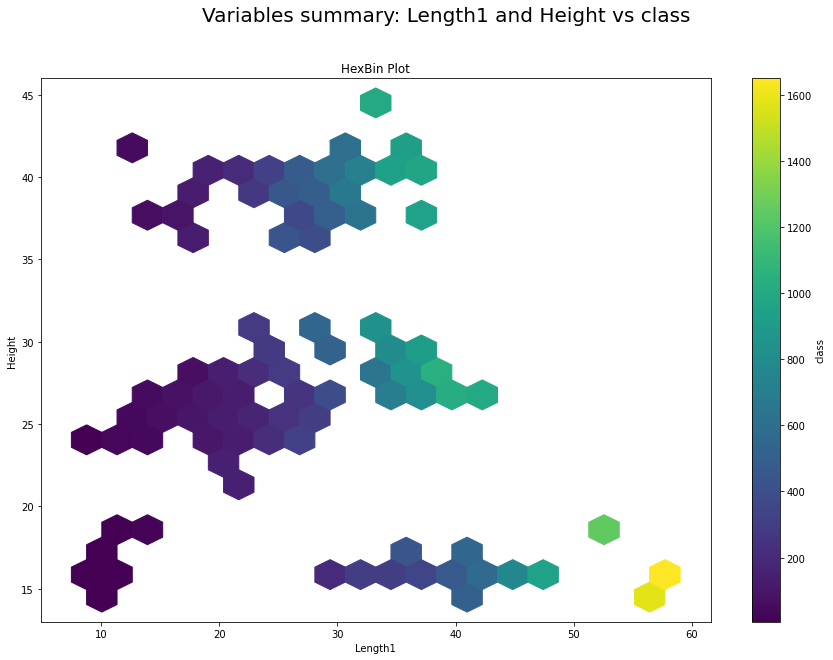

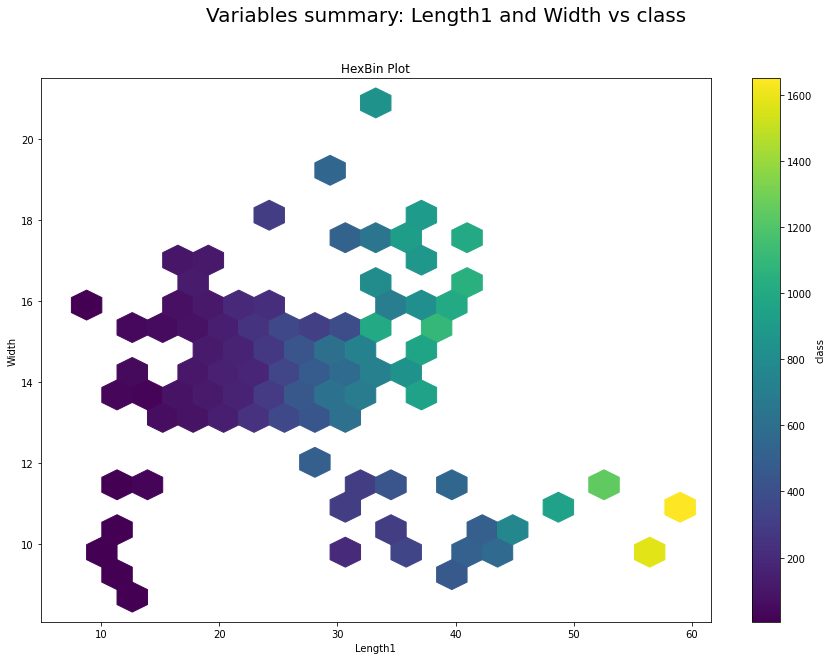

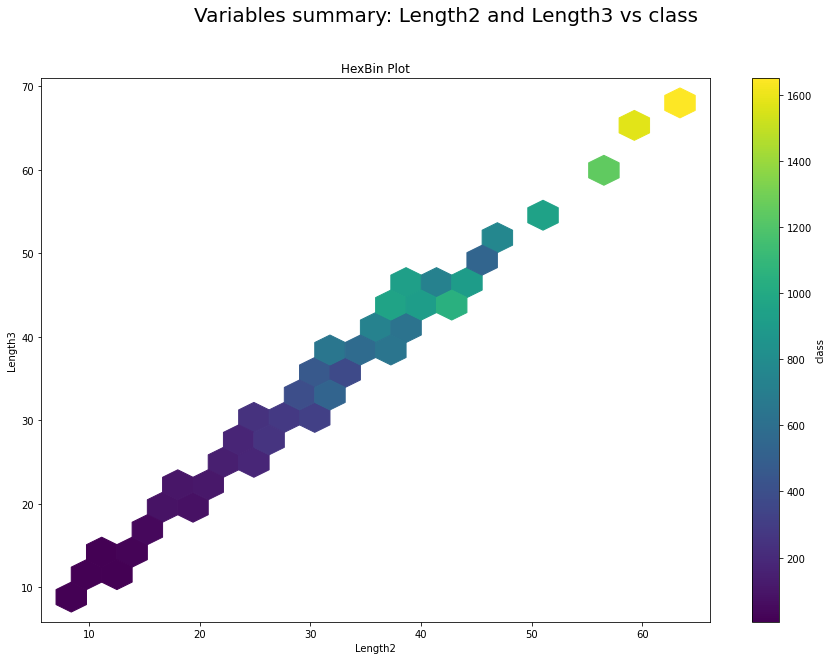

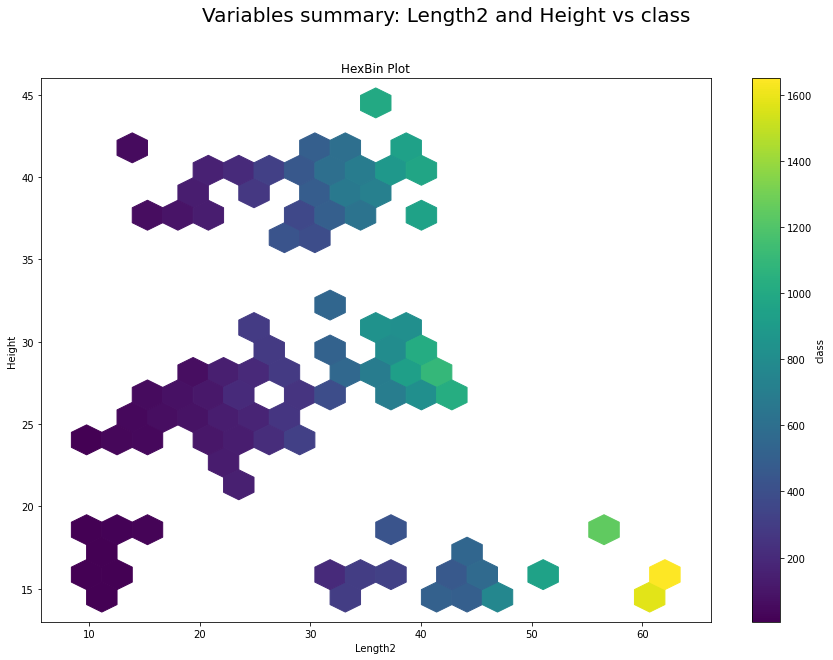

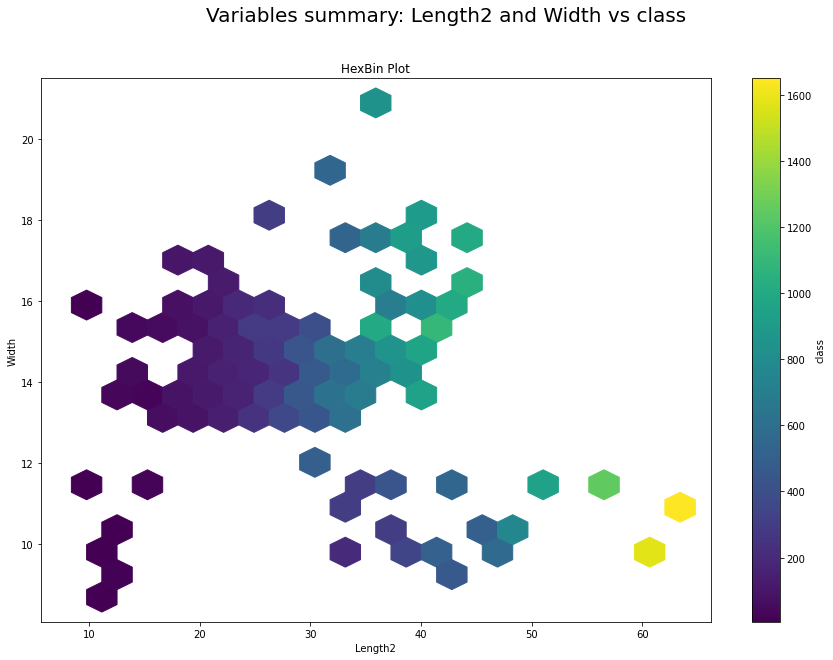

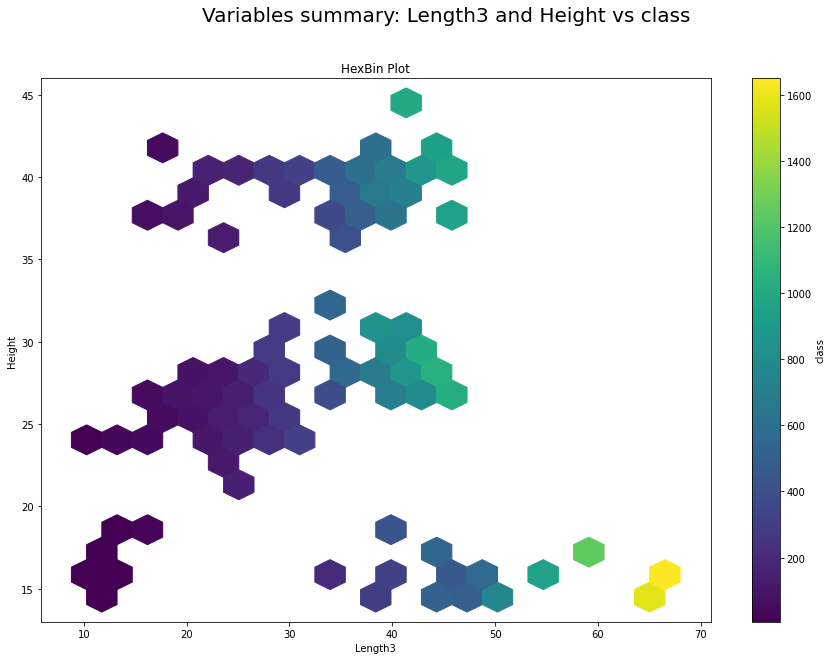

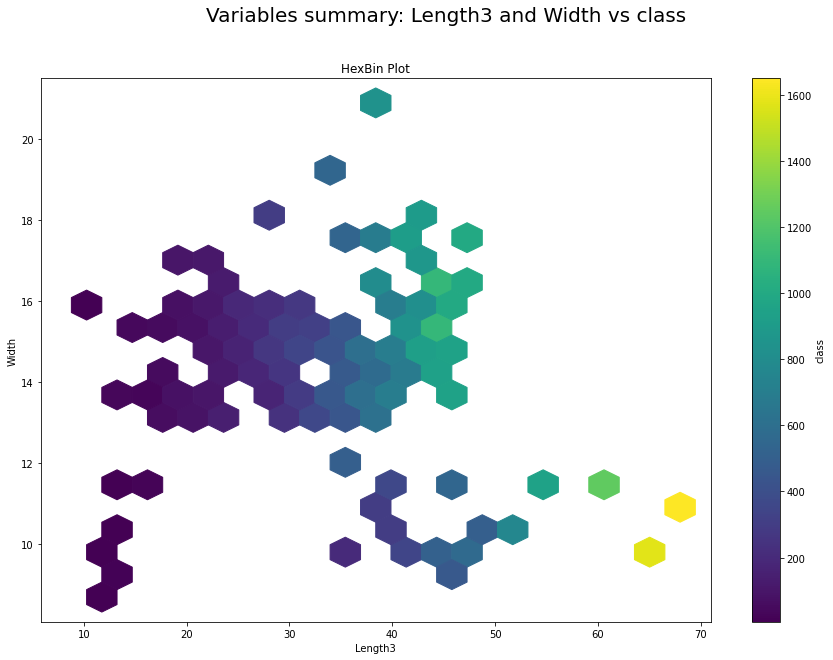

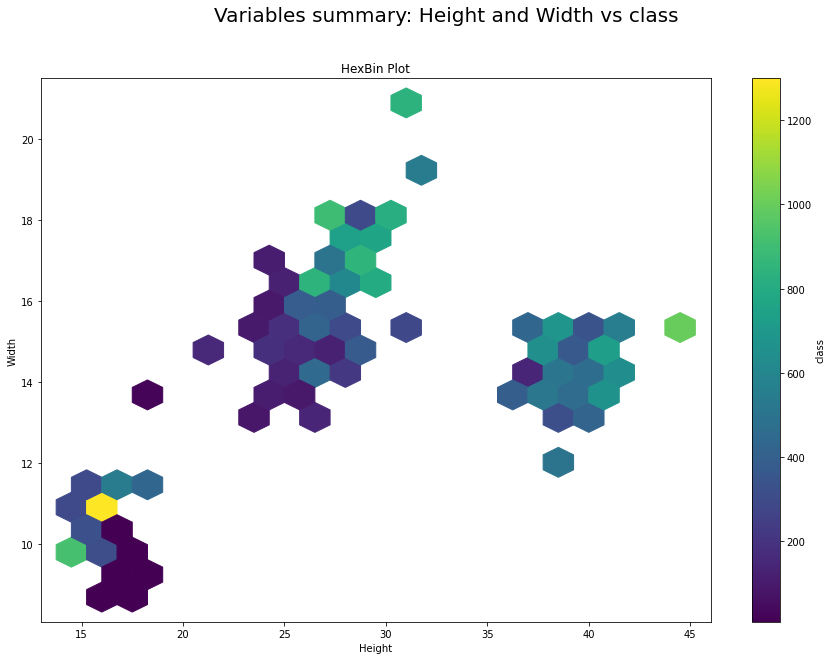

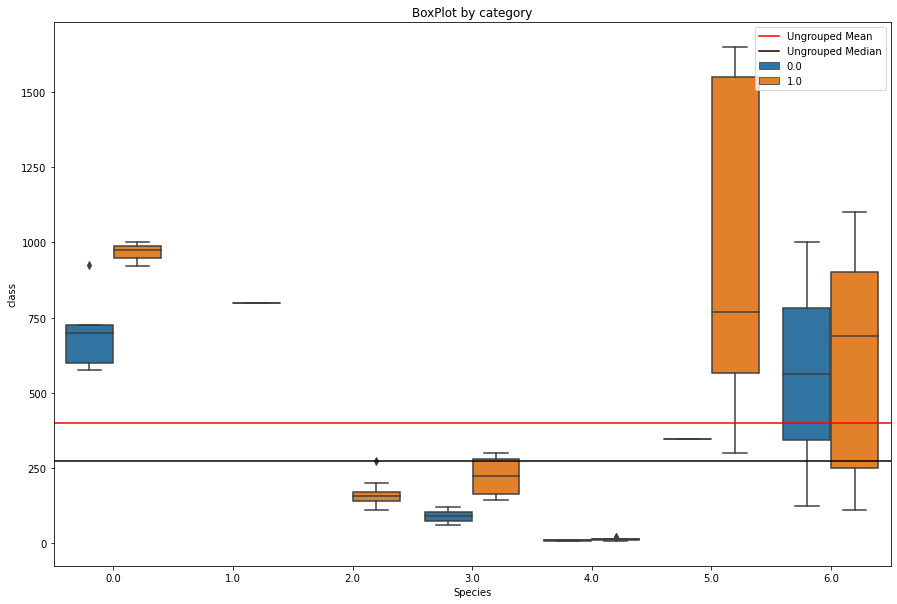

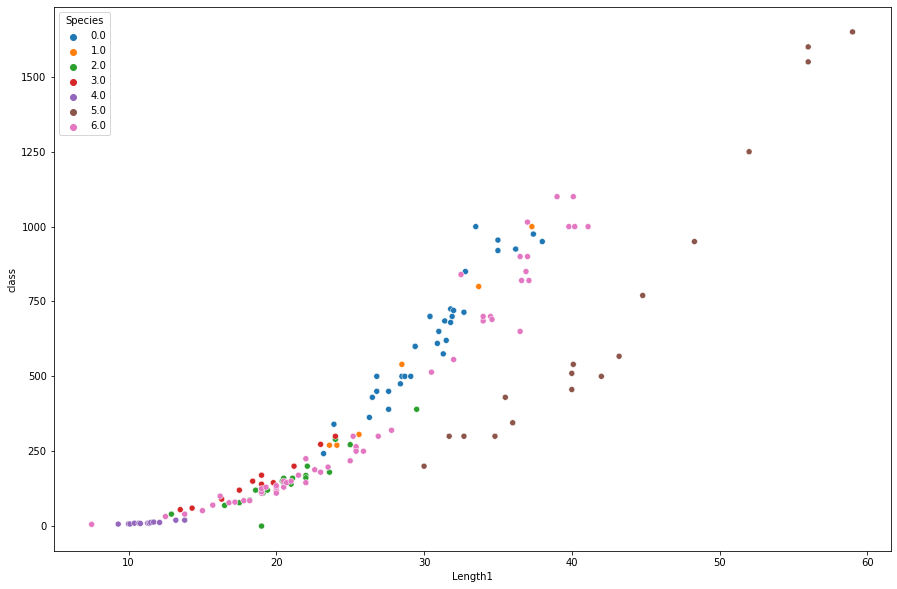

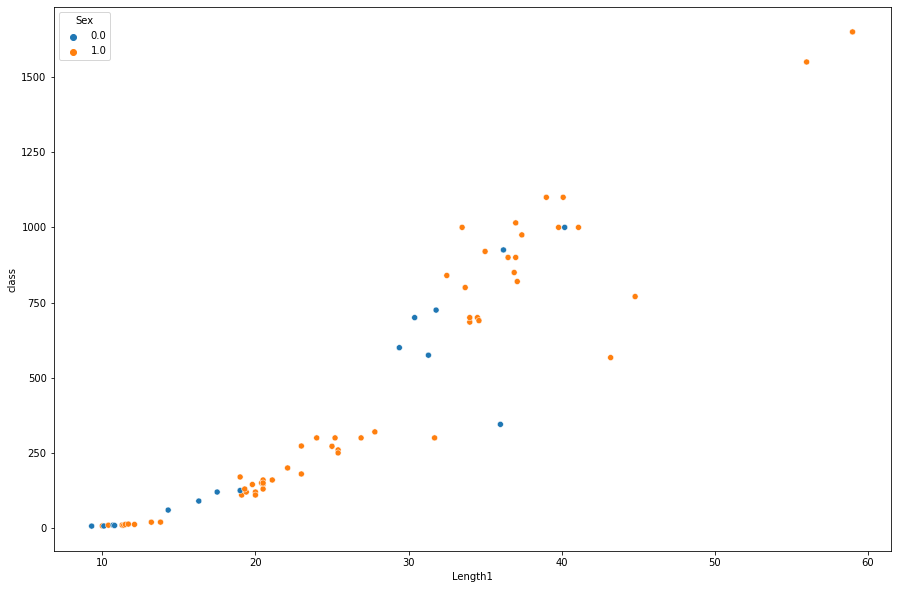

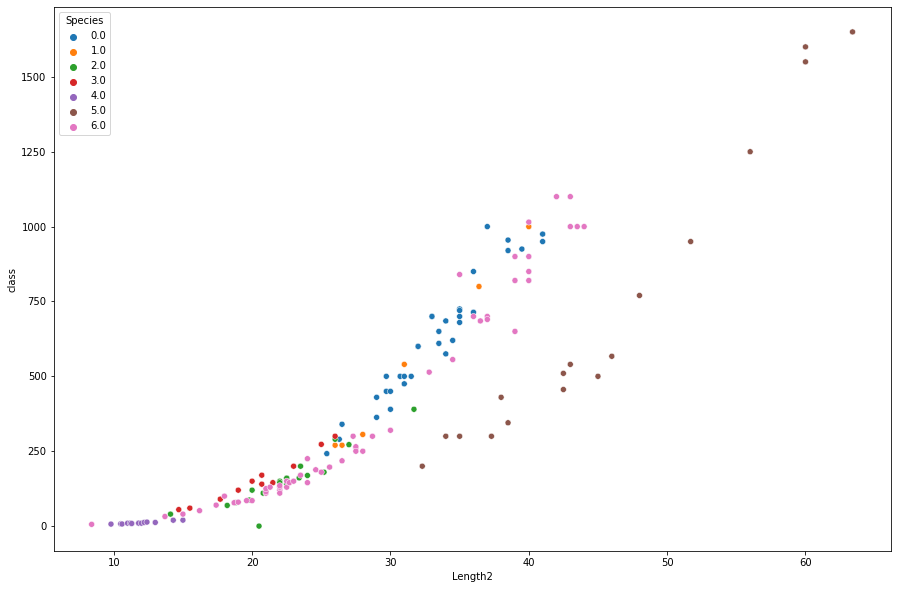

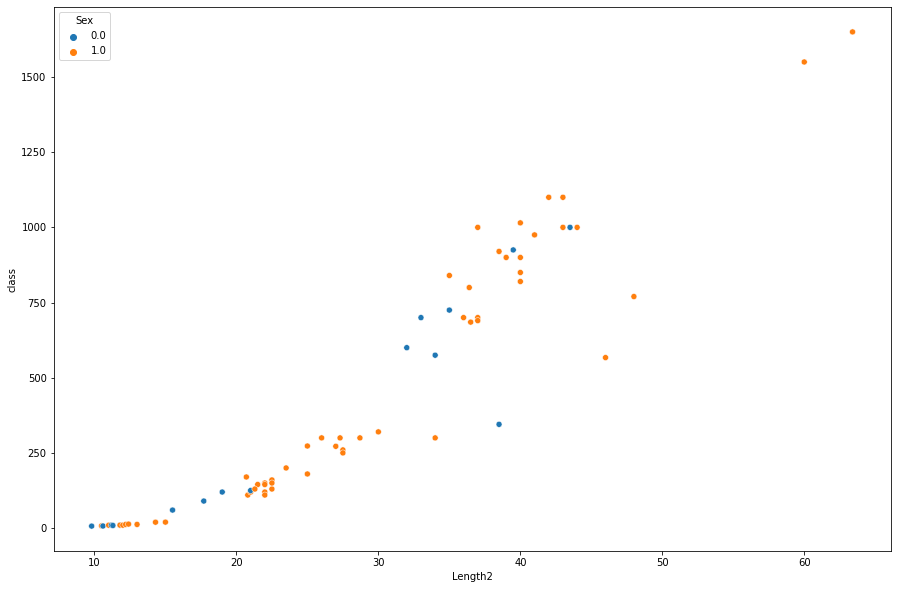

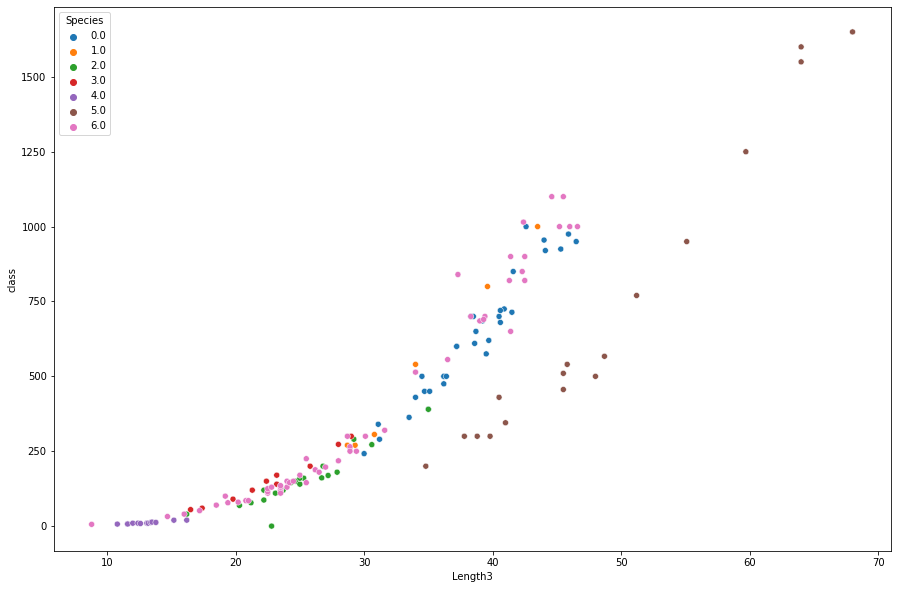

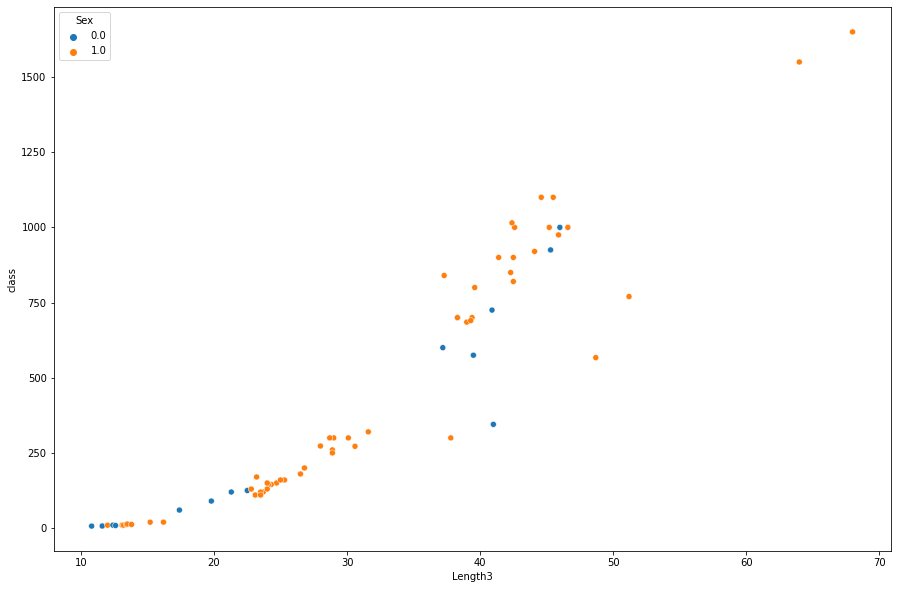

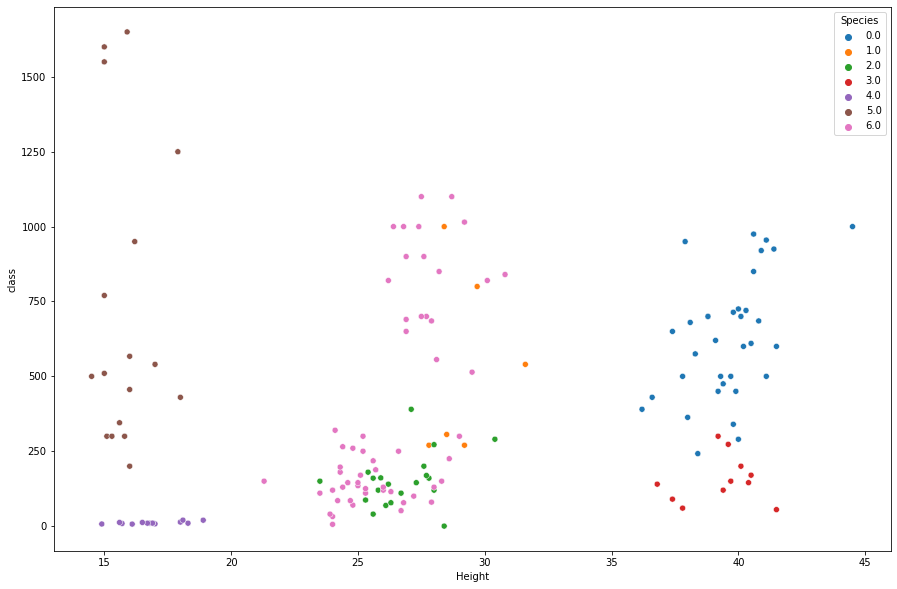

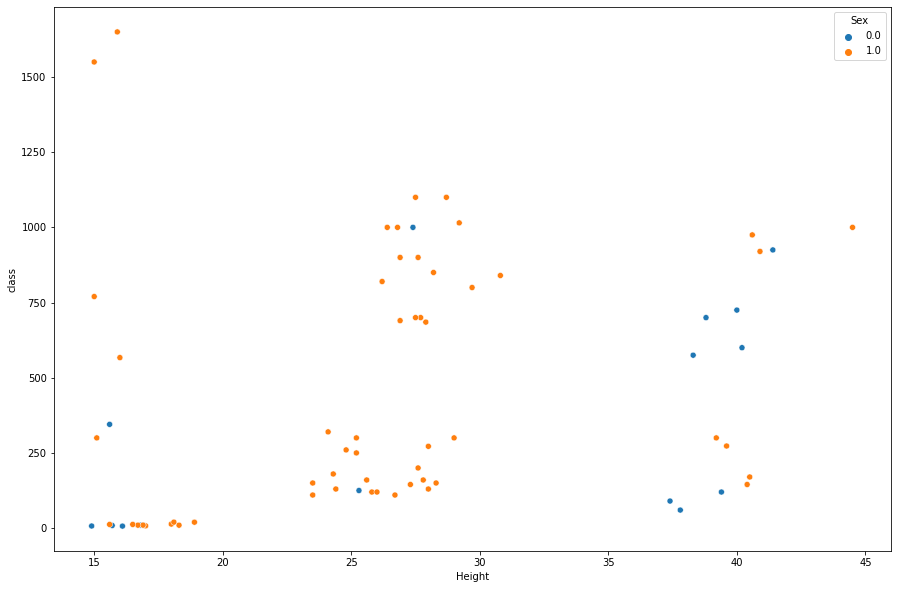

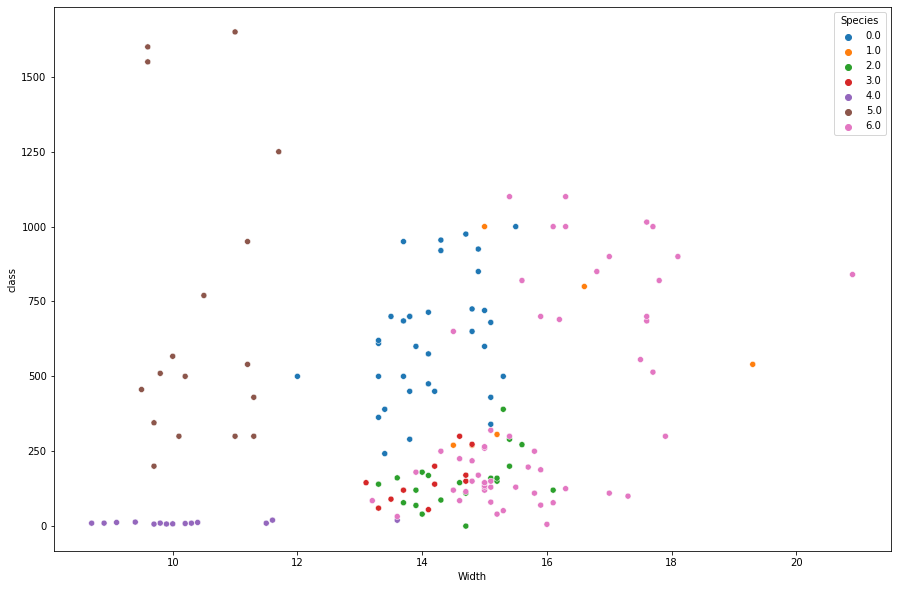

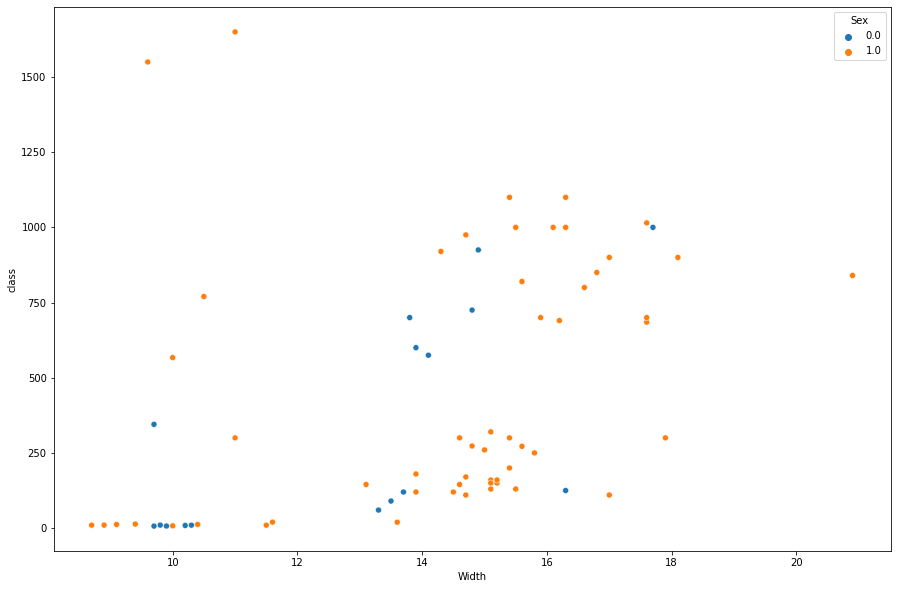

In [36]:
dataframe = df_fish
numerical_vars = ['Length1', 'Length2', 'Length3', 'Height', 'Width']
categorical_vars = ['Species', 'Sex']
target = 'class'
summary_dict_fish = eda.summaryEDA(dataframe, numerical_vars, categorical_vars, target, target_type='numerical');

In [43]:
summary_dict_fish.keys()

dict_keys(['Length1', 'Length2', 'Length3', 'Height', 'Width', 'Species', 'Sex', ('Length1', 'class'), ('Length2', 'class'), ('Length3', 'class'), ('Height', 'class'), ('Width', 'class'), ('Species', 'class'), ('Sex', 'class'), ('Length1', 'Length2', 'class'), ('Length1', 'Length3', 'class'), ('Length1', 'Height', 'class'), ('Length1', 'Width', 'class'), ('Length2', 'Length3', 'class'), ('Length2', 'Height', 'class'), ('Length2', 'Width', 'class'), ('Length3', 'Height', 'class'), ('Length3', 'Width', 'class'), ('Height', 'Width', 'class'), ('Species', 'Sex', 'class'), ('Length1', 'Species', 'class'), ('Length1', 'Sex', 'class'), ('Length2', 'Species', 'class'), ('Length2', 'Sex', 'class'), ('Length3', 'Species', 'class'), ('Length3', 'Sex', 'class'), ('Height', 'Species', 'class'), ('Height', 'Sex', 'class'), ('Width', 'Species', 'class'), ('Width', 'Sex', 'class')])

In [46]:
summary_dict_fish[("Length1", "Species","class")]["summary"]

,Length1,class,Length1_Species:0.0,Length1_Species:1.0,Length1_Species:2.0,Length1_Species:3.0,Length1_Species:4.0,Length1_Species:5.0,Length1_Species:6.0,class_Species:0.0,class_Species:1.0,class_Species:2.0,class_Species:3.0,class_Species:4.0,class_Species:5.0,class_Species:6.0
count,158.000000,158.000000,34.000000,6.000000,20.000000,11.000000,14.000000,17.000000,56.000000,34.000000,6.000000,20.000000,11.000000,14.000000,17.000000,56.000000
mean,26.226582,398.695570,30.329412,28.800000,20.645000,18.727273,11.257143,42.476471,25.735714,626.000000,531.000000,152.050000,154.818182,11.178571,718.705882,382.239286
std,10.024844,359.086204,3.644966,5.580681,3.459917,3.284841,1.216372,9.029087,8.561572,206.604585,309.602972,88.828916,78.755086,4.131526,494.140765,347.617717
min,7.500000,0.000000,23.200000,23.600000,12.900000,13.500000,9.300000,30.000000,7.500000,242.000000,270.000000,0.000000,55.000000,6.700000,200.000000,5.900000
25%,19.025000,120.000000,27.800000,24.475000,18.900000,16.900000,10.475000,35.500000,19.825000,481.250000,279.000000,104.250000,105.000000,8.950000,345.000000,120.000000
50%,25.100000,272.500000,30.650000,27.050000,20.500000,19.000000,11.300000,40.100000,23.250000,615.000000,423.000000,147.500000,145.000000,9.850000,510.000000,207.500000
75%,32.700000,650.000000,31.975000,32.400000,22.025000,20.500000,11.650000,48.300000,34.125000,718.500000,735.000000,171.750000,185.000000,12.200000,950.000000,692.500000
max,59.000000,1650.000000,38.000000,37.300000,29.500000,24.000000,13.800000,59.000000,41.100000,1000.000000,1000.000000,390.000000,300.000000,19.900000,1650.000000,1100.000000


In [77]:
df_fish.columns

Index(['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width', 'Sex',
       'class'],
      dtype='object')

In [18]:
corr_dict = nominal.compute_associations(dataframe, theil_u=True, clustering=True,
                    nan_strategy='drop_samples',
                    mark_columns=True)

In [19]:
corr_dict

,Name (nom),Ticket (nom),Cabin (nom),Survived (nom),Pclass (nom),Sex (nom),Embarked (nom),SibSp (con),Parch (con),Fare (con),PassengerId (con),Age (con)
Name (nom),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Ticket (nom),0.910171,1.000000,0.968382,0.781301,1.000000,0.690770,0.989270,0.924306,0.940326,1.000000,0.894709,0.864027
Cabin (nom),0.920735,0.979622,1.000000,0.770912,1.000000,0.729169,0.974490,0.961750,0.968549,0.937363,0.907671,0.921372
Survived (nom),0.121444,0.104249,0.101682,1.000000,0.013790,0.228201,0.008544,0.106346,0.023582,0.134241,0.148495,0.254085
Pclass (nom),0.094195,0.103491,0.102304,0.010696,1.000000,0.003826,0.056916,0.105744,0.075933,0.330677,0.138919,0.312825
Sex (nom),0.132914,0.100875,0.105261,0.249755,0.005399,1.000000,0.002840,0.104291,0.089581,0.130433,0.025205,0.184969
Embarked (nom),0.135522,0.147300,0.143434,0.009535,0.081887,0.002896,1.000000,0.174974,0.103813,0.242843,0.066022,0.088832
SibSp (con),1.000000,0.924306,0.961750,0.106346,0.105744,0.104291,0.174974,1.000000,0.255346,0.286433,-0.083488,-0.156162
Parch (con),1.000000,0.940326,0.968549,0.023582,0.075933,0.089581,0.103813,0.255346,1.000000,0.389740,-0.051454,-0.271271
Fare (con),1.000000,1.000000,0.937363,0.134241,0.330677,0.130433,0.242843,0.286433,0.389740,1.000000,0.029740,-0.092424


df_corr, df_corr_ordered, (fig, ax) = eda.associations(dataframe)

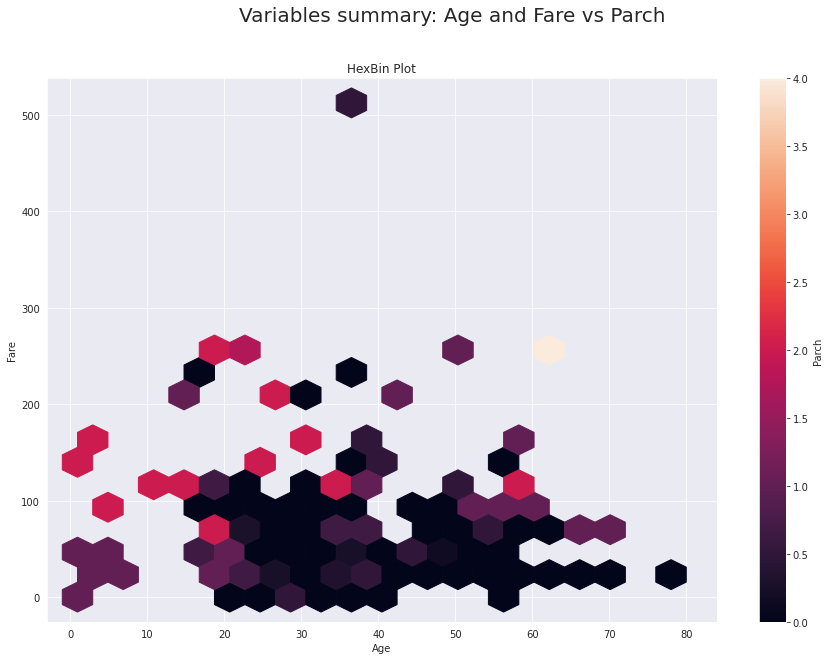

((<Figure size 1080x720 with 2 Axes>,
  <AxesSubplot:title={'center':'HexBin Plot'}, xlabel='Age', ylabel='Fare'>),
               Age        Fare       Parch
 count  183.000000  183.000000  183.000000
 mean    35.674426   78.682469    0.475410
 std     15.643866   76.347843    0.754617
 min      0.920000    0.000000    0.000000
 25%     24.000000   29.700000    0.000000
 50%     36.000000   57.000000    0.000000
 75%     47.500000   90.000000    1.000000
 max     80.000000  512.329200    4.000000)

In [59]:
eda.two_numerical_vs_numerical(dataframe, "Age", "Fare", "Parch", 
                                 palette=None, ax=None, order=None)

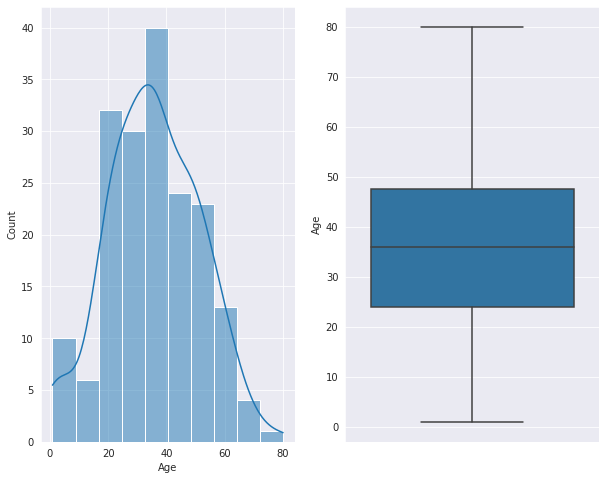

((<Figure size 720x576 with 2 Axes>,
  array([<AxesSubplot:xlabel='Age', ylabel='Count'>,
         <AxesSubplot:ylabel='Age'>], dtype=object)),
 count    183.000000
 mean      35.674426
 std       15.643866
 min        0.920000
 25%       24.000000
 50%       36.000000
 75%       47.500000
 max       80.000000
 Name: Age, dtype: float64)

In [60]:
eda.numerical_univariate(dataframe, 'Age', palette=None, ax=None)

<IPython.core.display.Javascript object>


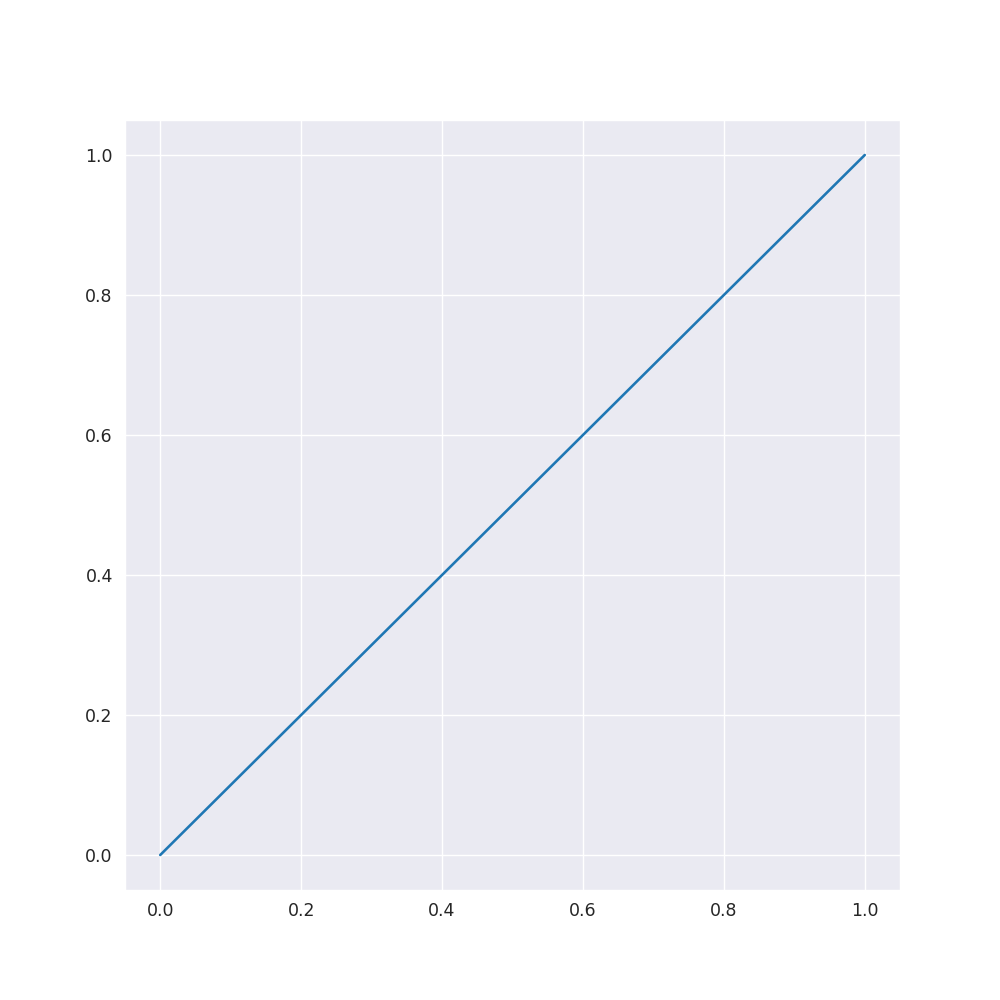

In [84]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot([0,1], [0,1])

In [90]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [98]:
my_dictionary = {
    'fig_test': fig,
    'ax_test': ax
}

In [99]:
save_obj(my_dictionary, "test_dictionary")

### Summary tables

* Categorical: count_values and pct
* Numerical: Describe

* Categorical vs Numerical: Describe for whole numerical and describe for each category
* Categorical vs Categorical: count values and pct for both vars alone, crosstab and crosstab with pct
* Numerical vs Numerical: Describe for both variables

* 2 categorical vs categorical: crosstab with index the first 2 categorical, and column the third categ
* 2 categorical vs numerical: Describe for each combination
* 2 numerical vs categorical: Describe for both numerical alone and for each category

In [21]:
dataframe.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [35]:
pd.__version__

'1.1.2'

In [42]:
eda.compute_summary_categorical_vs_categorical(dataframe, 'Pclass', 'Sex')

(Sex     female  male  All
 Pclass                   
 1           74    84  158
 2            9     6   15
 3            5     5   10
 All         88    95  183,
 Sex       female      male
 Pclass                    
 1       0.468354  0.531646
 2       0.600000  0.400000
 3       0.500000  0.500000
 All     0.480874  0.519126)